# 1. Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import keras
import warnings
warnings.filterwarnings('ignore')

# 2. Import Dataset

In [2]:
X1 = pd.read_csv("X1.csv")
X1.drop(columns = ["Unnamed: 0"])
Y1 = pd.read_csv("Y1.csv", header = None, names = ["revenue"])

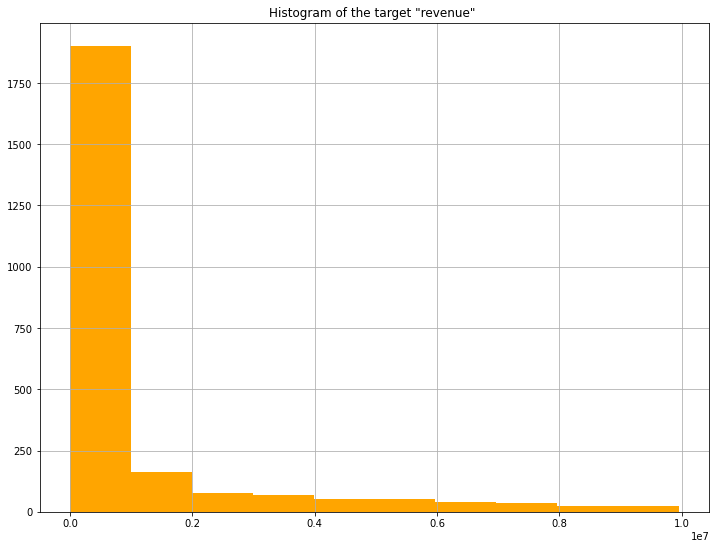

In [3]:
plt.figure(figsize = (12,9))
plt.hist(Y1[Y1["revenue"] < 1e7].values, color = "orange")
plt.grid()
plt.title("Histogram of the target \"revenue\" ")
#plt.savefig("Histogram_target_low.svg")
plt.show()

# 3. First Prediction

## 3.1 Features Engineering

In [4]:
# Here only some relevant features at first sight evaluation will be kept => mainly the numerical features
features = ["ratings", "n_votes", "is_adult", "production_year", "runtime", "genres", "release_year"]
df1 = X1[features]

In [5]:
# Drop NaN values (that are stored as \\N)
for col in df1.columns : 
    df1.drop(df1[df1[col] == "\\N"].index, inplace=True)

df1.reset_index(inplace=True)

for i in range(len(df1)) :
    df1["runtime"][i] = int(df1.iloc[i]["runtime"])

In [6]:
# Actually genres is a categorical feature => Need to be transformed in a numerical one

lst_genres = list()

for i in range(len(df1["genres"])) :
    lst_genres += df1["genres"].loc[i].split(",")

In [7]:
np.unique(lst_genres)

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller',
       'War', 'Western'], dtype='<U11')

In [8]:
cat_genre = np.unique(lst_genres)
df1[cat_genre] = 0 # initialize empty columns

for i in range(len(df1)) :
    genre = df1["genres"][i]
    genre = genre.split(",")
    for j in genre :
        df1[j][i] = 1

df1.drop(columns = ["genres"], inplace=True)

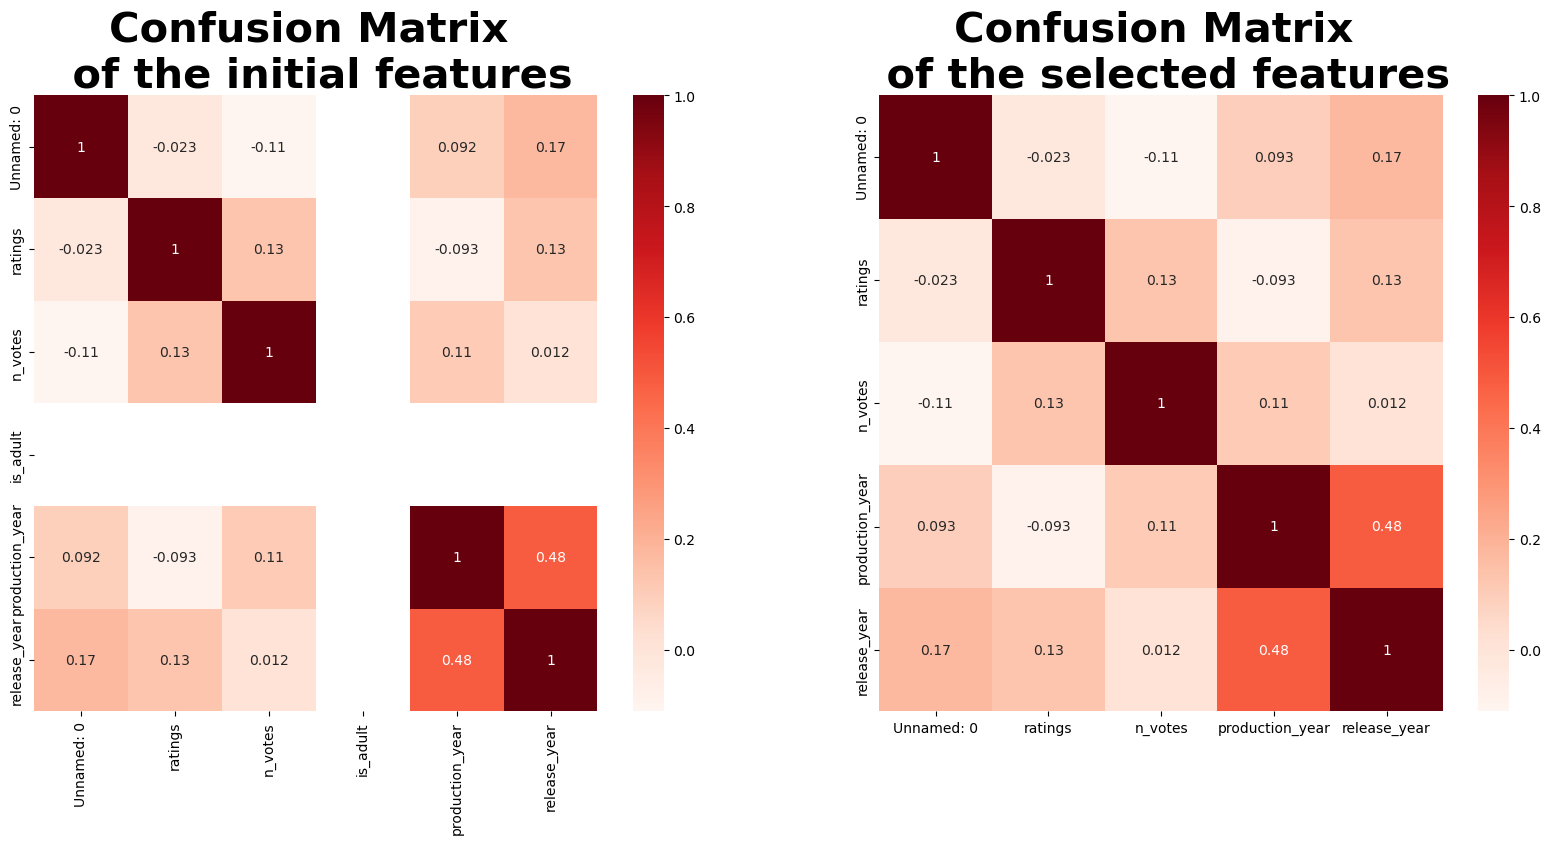

In [9]:
matplotlib.style.use("default")
plt.figure(figsize=(20,8))
plt.subplot(121)
corr = X1.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.title("Confusion Matrix \n of the initial features", fontweight="bold", fontsize = 30)




tmp = X1[1:].drop("is_adult", axis=1)
plt.subplot(122)
corr = tmp.corr()
plt.title("Confusion Matrix \n of the selected features", fontweight="bold", fontsize = 30)
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)


#plt.savefig("Correlation.svg")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix \n with "genres" features')

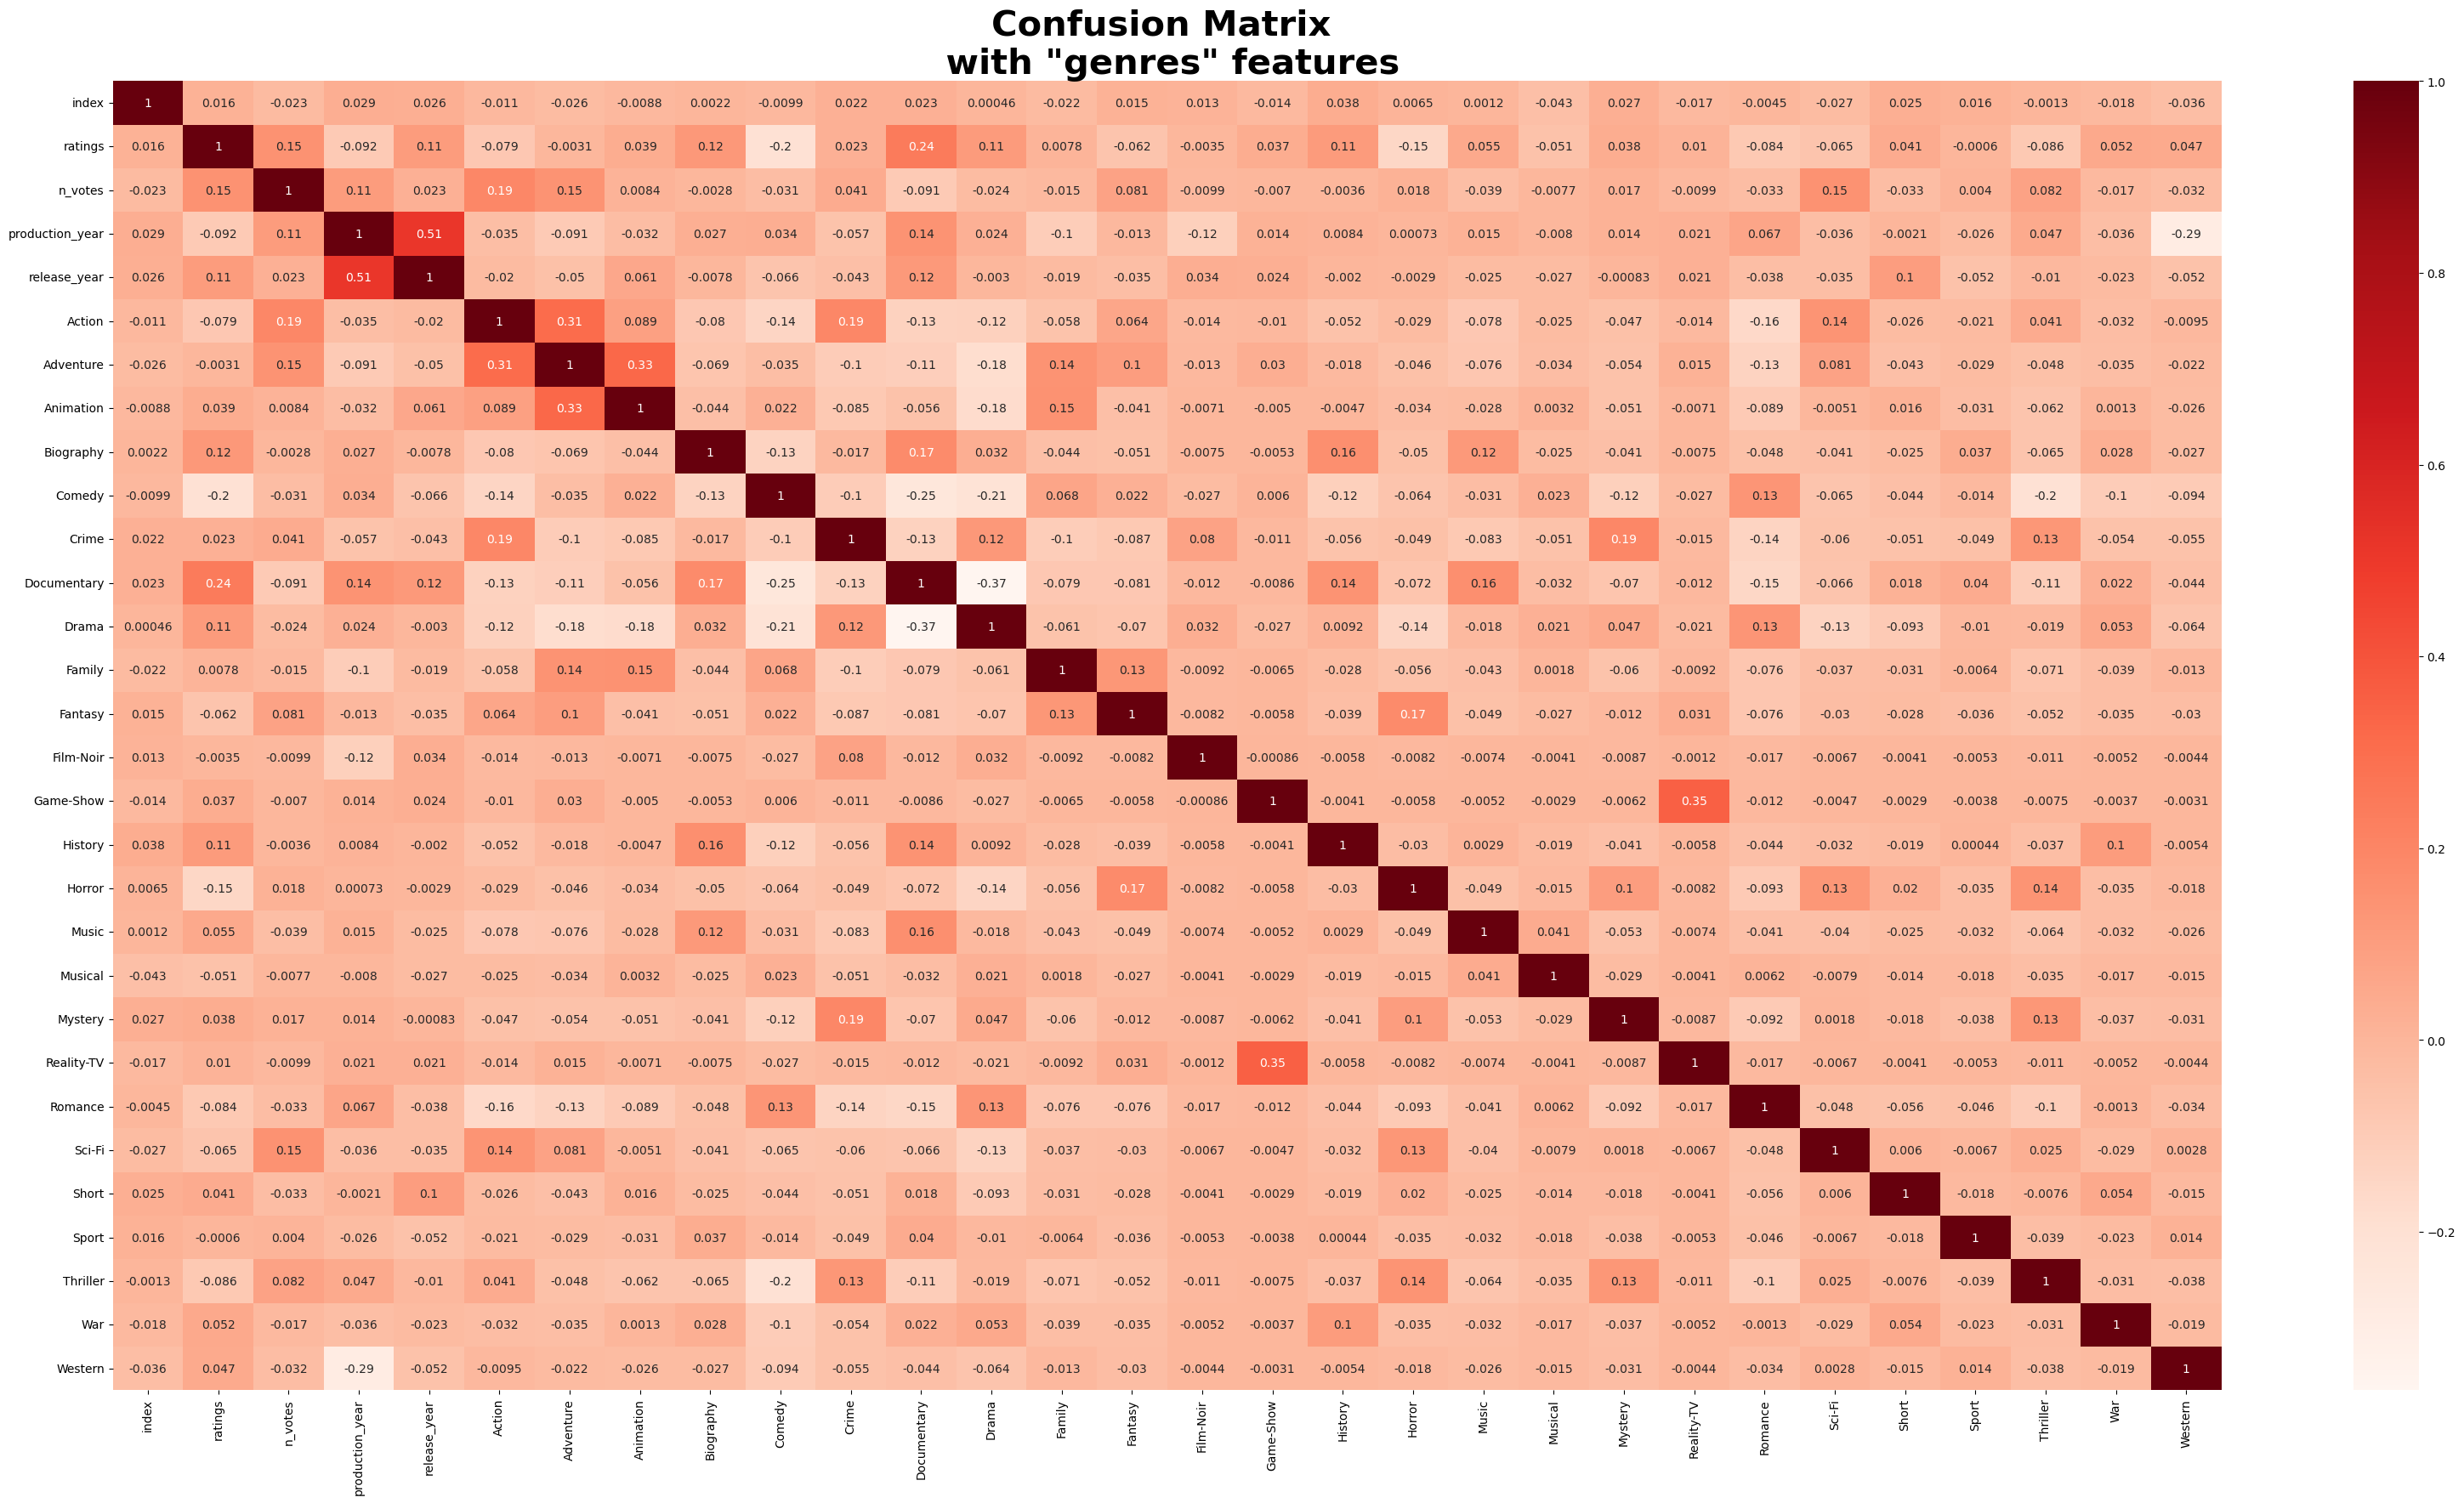

In [10]:
matplotlib.style.use("default")
plt.figure(figsize=(40,20))
corr = df1.drop(columns = ["is_adult"]).corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.title("Confusion Matrix \n with \"genres\" features", fontweight="bold", fontsize = 30)
#plt.savefig("correlation_genre.svg")

In [11]:
visu_data = df1[["ratings", "n_votes", "production_year", "runtime", "release_year"]]
visu_data["revenue"] = Y1.iloc[df1["index"]]["revenue"].values

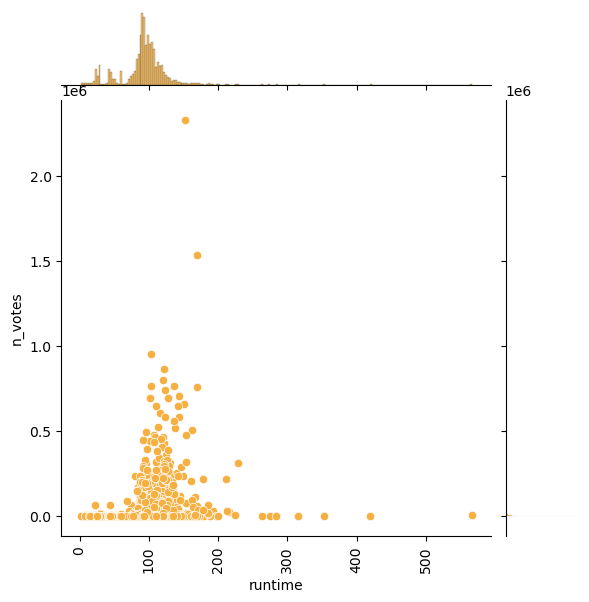

In [12]:
g = sns.jointplot("runtime", "n_votes", data=visu_data, color='#F5B041')
#g.ax_joint.set_xticks(np.linspace(float(min(visu_data["n_votes"])), float(max(visu_data["n_votes"])), 10))
for tick in g.ax_joint.get_xticklabels():         
    tick.set_rotation(90)
#plt.savefig("nb_votes_vs_runtime.svg", bbox_inches = 'tight')
plt.show()

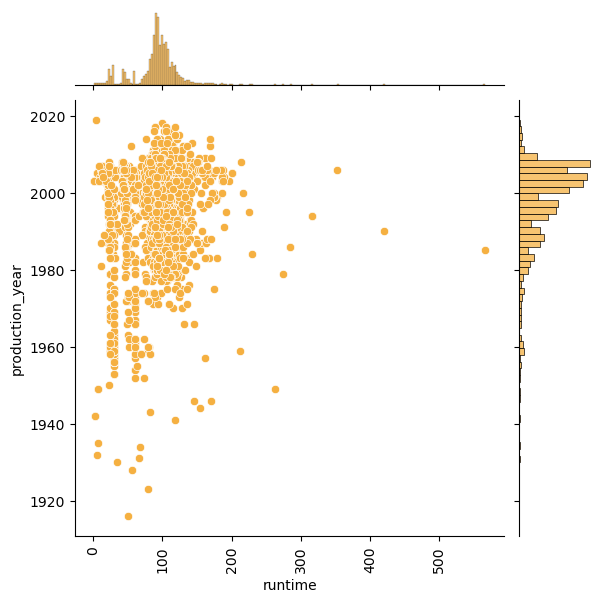

In [13]:
g = sns.jointplot("runtime", "production_year", data=visu_data, color='#F5B041')
#g.ax_joint.set_xticks(np.linspace(int(min(visu_data["production_year"])), int(max(visu_data["production_year"])), 10))
for tick in g.ax_joint.get_xticklabels():         
    tick.set_rotation(90)
#plt.savefig("prod_year_vs_runtime.svg", bbox_inches = 'tight')
plt.show()

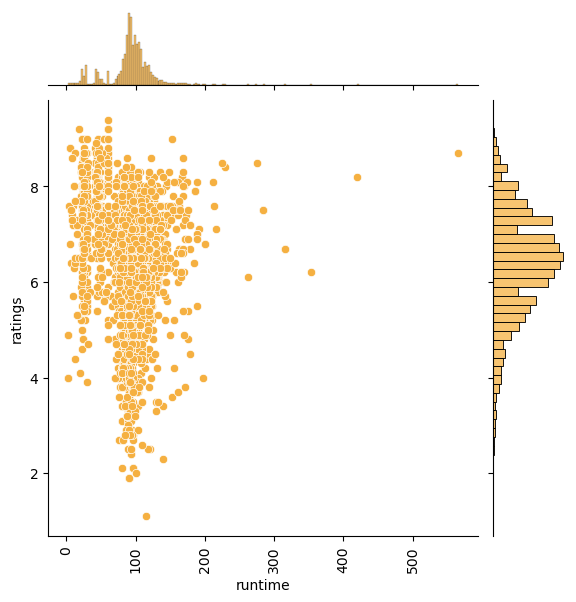

In [14]:
g = sns.jointplot("runtime", "ratings", data=visu_data, color='#F5B041')
#g.ax_joint.set_xticks(np.linspace(int(min(visu_data["ratings"])), int(max(visu_data["ratings"])), 10))
for tick in g.ax_joint.get_xticklabels():         
    tick.set_rotation(90)
#plt.savefig("ratings_vs_runtime.svg", bbox_inches = 'tight')
plt.show()

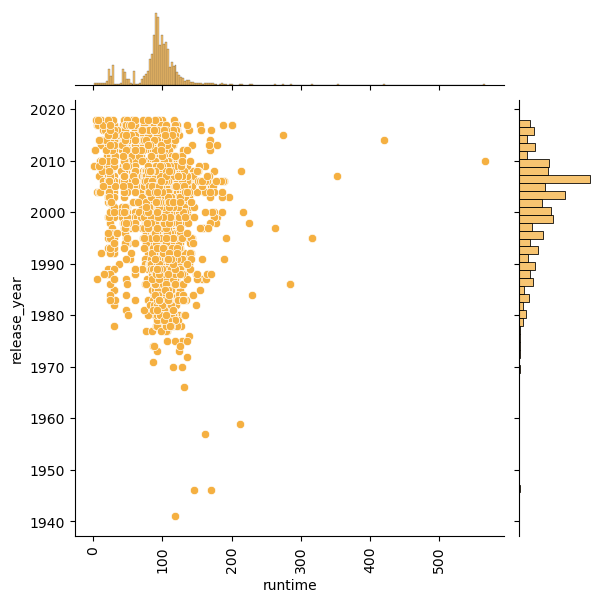

In [15]:
g = sns.jointplot("runtime", "release_year", data=visu_data, color='#F5B041')
#g.ax_joint.set_xticks(np.linspace(int(min(visu_data["release_year"])), int(max(visu_data["release_year"])), 10))
for tick in g.ax_joint.get_xticklabels():         
    tick.set_rotation(90)
#plt.savefig("release_year_vs_runtime.svg", bbox_inches = 'tight')
plt.show()

### Outliers Removal

The columns 0 named ratings dropped 1 elements !
The columns 1 named n_votes dropped 38 elements !
The columns 2 named production_year dropped 56 elements !
The columns 3 named release_year dropped 58 elements !


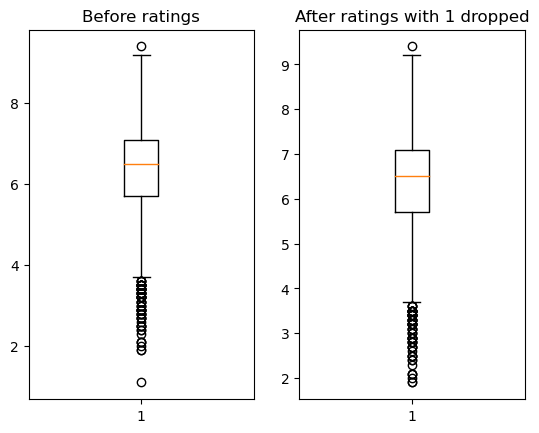

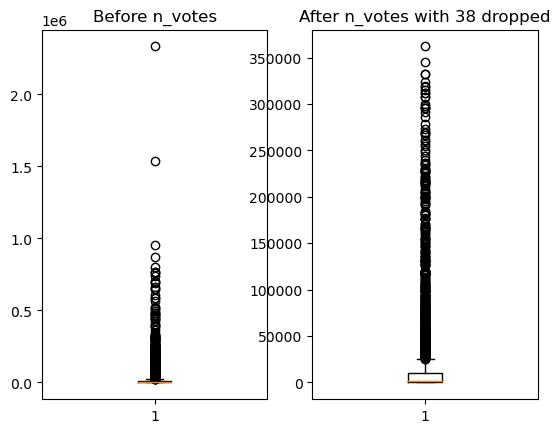

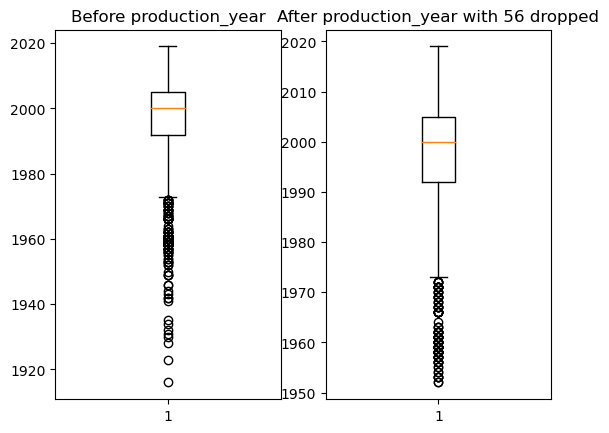

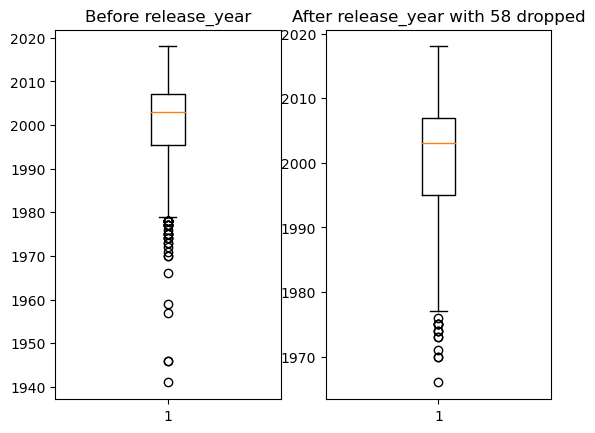

In [16]:
X2 = visu_data.drop(columns=["revenue", "runtime"])
y2 = Y1.copy()

X3 = X2.copy()
y3 = y2.copy()

for i, col in enumerate(X2.columns) :
    
    fig1, (ax1, ax2) = plt.subplots(1,2)
    
    
    nb_init = len(X2[col])
    
    mean = np.mean(X2[col].values)
    std = np.std(X2[col].values)
    
    idx1 = X3[X3[col] > mean + 4*std].index
    idx2 = X3[X3[col] < mean - 4*std].index
    X3.drop(idx1, inplace=True)
    X3.drop(idx2, inplace=True)
    
    y3.drop(idx1, inplace=True)
    y3.drop(idx2, inplace=True)

    nb_final = len(X3[col])
    
    print(f"The columns {i} named {col} dropped {nb_init-nb_final} elements !")

    
    ax1.set_title(f'Before {col}')
    ax1.boxplot(X2[col].values)
    
    ax2.set_title(f'After {col} with {nb_init-nb_final} dropped')
    ax2.boxplot(X3[col].values)

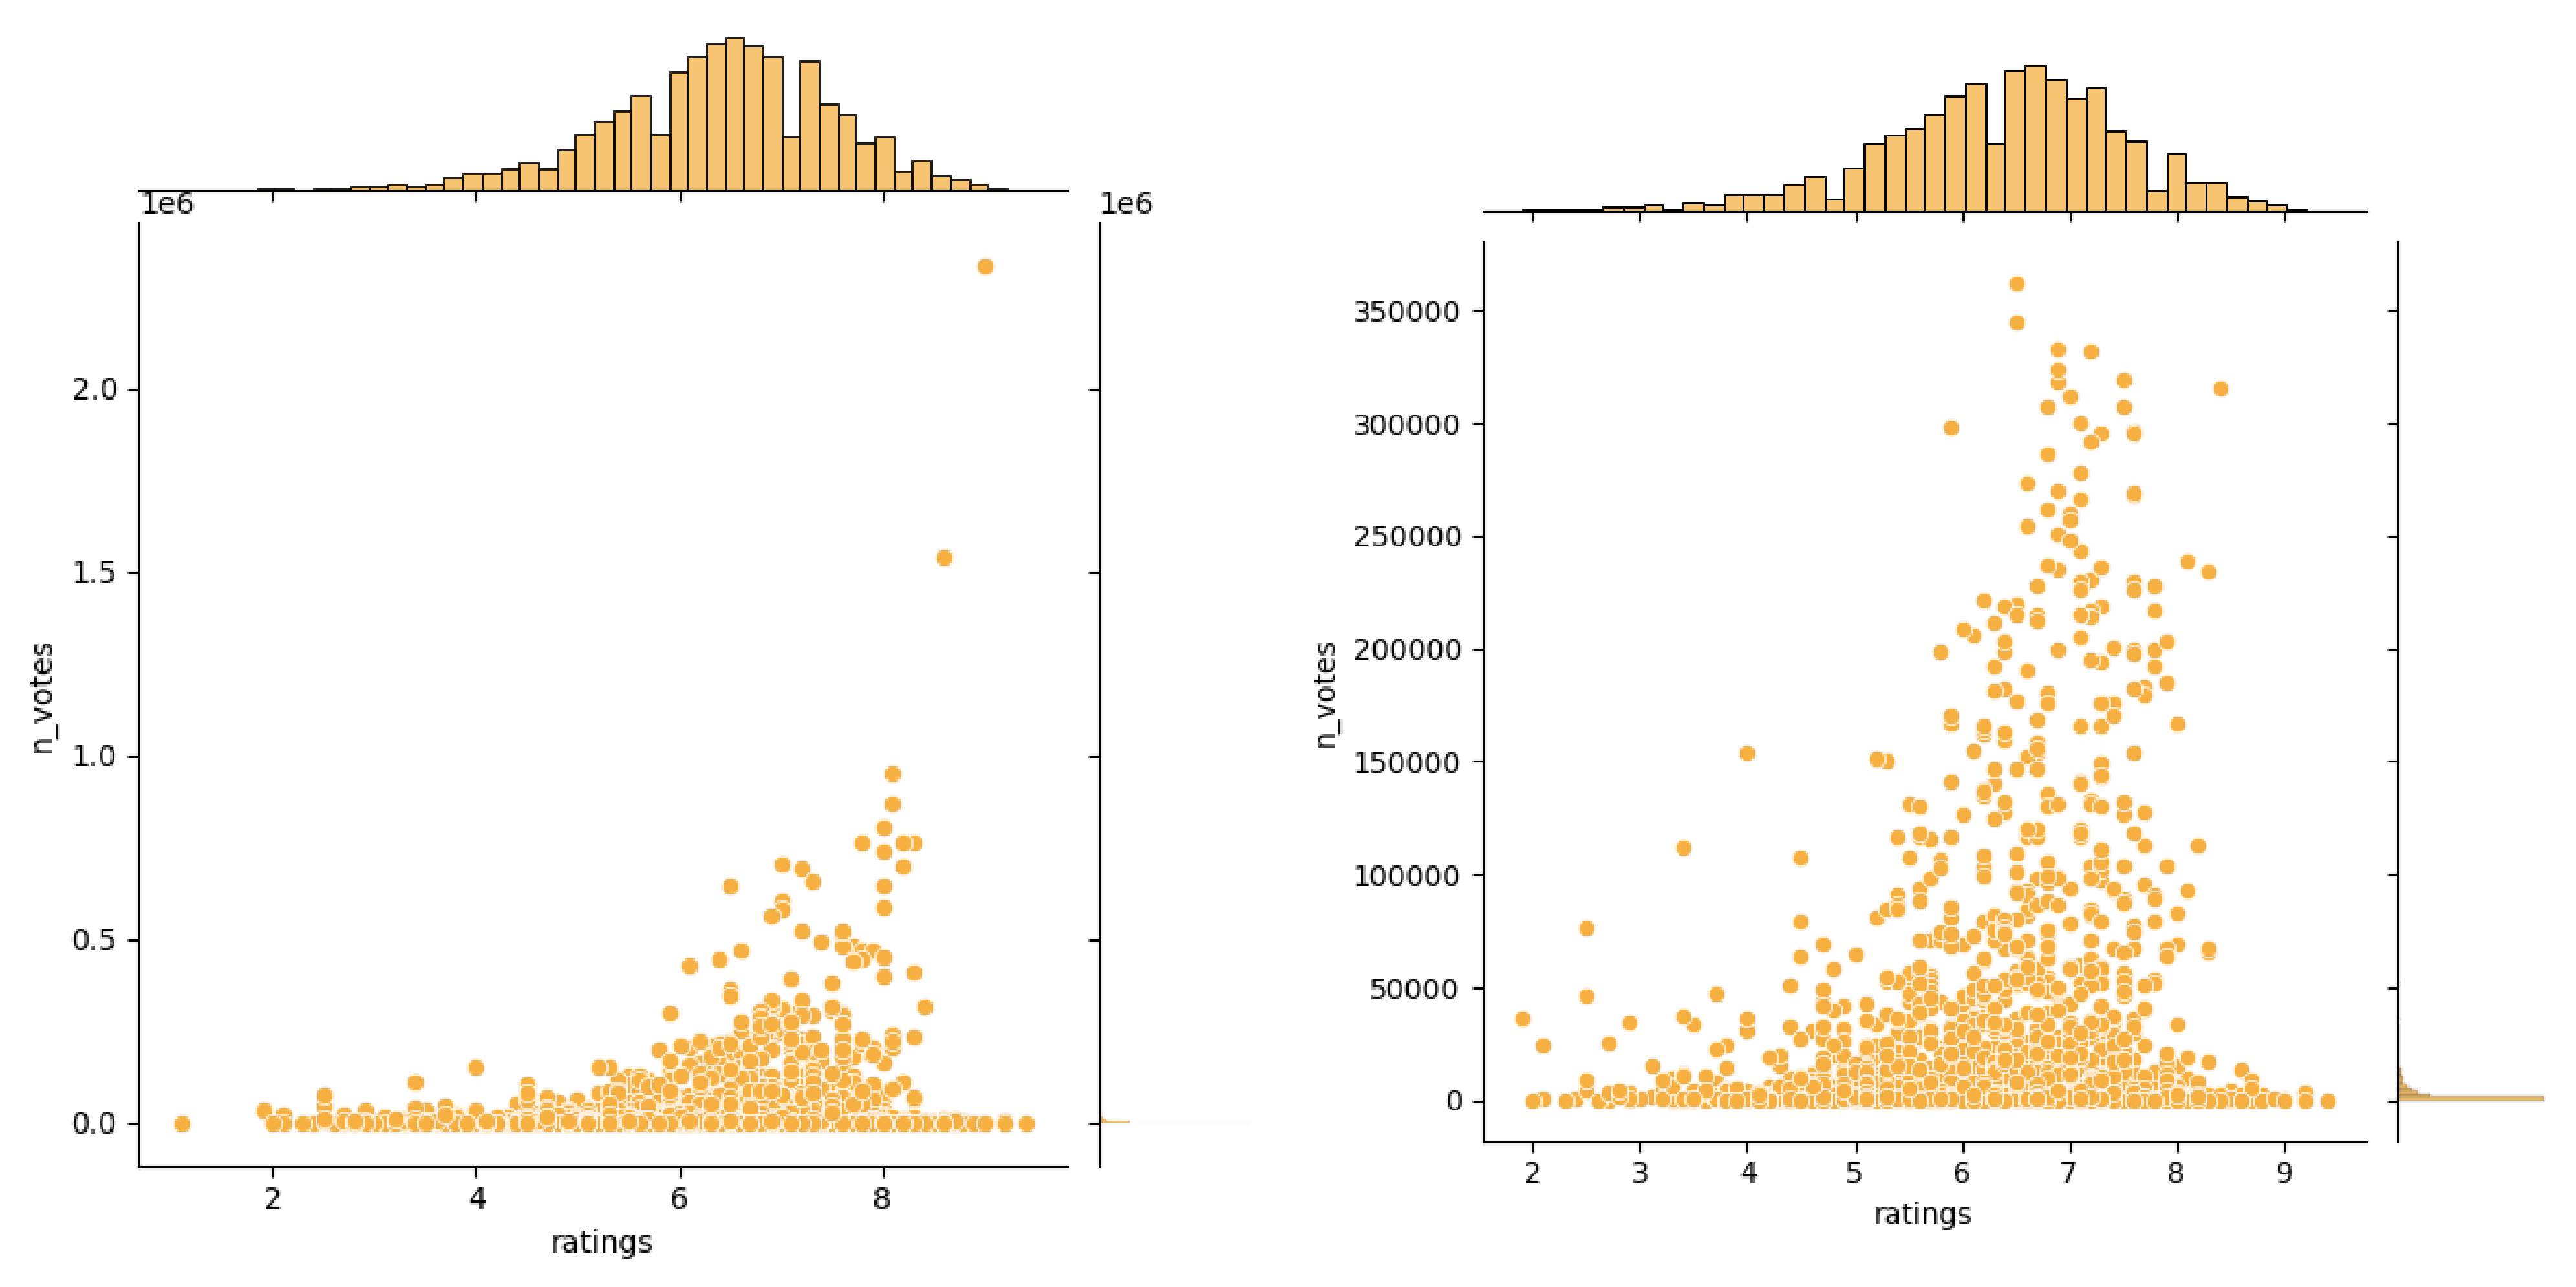

In [17]:
import matplotlib.image as mpimg


g0 = sns.jointplot("ratings", "n_votes", data=visu_data, color='#F5B041')
#plt.title("Before removing outliers", fontweight="bold", fontsize = 30)

g1= sns.jointplot("ratings", "n_votes", data=X3, color='#F5B041')
#plt.title("After removing outliers", fontweight="bold", fontsize = 30)


g0.savefig('g0.png')
plt.close(g0.fig)

g1.savefig('g1.png')
plt.close(g1.fig)




f, axarr = plt.subplots(1, 2, figsize=(40, 20))

axarr[0].imshow(mpimg.imread('g0.png'))
axarr[1].imshow(mpimg.imread('g1.png'))


# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.savefig("before_after_outliers.svg")
plt.show()

## 3.0 Setup for prediction with K-fold for any model

In [18]:
def pred_with_model(model, X_train, y_train, X_test, y_test) :
    


    if isinstance(model, keras.engine.sequential.Sequential) :
        history = model.fit(X_train, y_train, epochs=10, 
                             batch_size=32, 
                             verbose=0,
                             shuffle=False)
        
        y_preds = y_test.copy()
        for i in range(len(y_preds)) :
            x = tf.convert_to_tensor(X_test.iloc[i].values.reshape(1, X_test.shape[-1]), dtype=tf.int64) 
            y_preds.iloc[i] = model.predict(x)
        

        
    else : 
        model.fit(X_train, y_train)
        history = None
        y_preds = model.predict(X_test)
    
    
        
    return y_preds, history

In [19]:
def compute_rmse(predict, target):
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)

### Predictions using K-FOLD

In [20]:
from sklearn.model_selection import KFold


def kfold_with_model(model, X, y, nb_split = 5) :
    """
    X : Training set
    y : Training set target
    
    """
    kf = KFold(n_splits=nb_split)
    RMSE = list()

    idx = 1
    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        y_preds, history = pred_with_model(model, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
        
        
        actual_rmse = compute_rmse(y_preds, y_test_fold)
        RMSE.append(actual_rmse)
        print(f"The RMSE at iteration {idx} of K-Fold is {actual_rmse}")
        
        
        if isinstance(model, keras.engine.sequential.Sequential) :
            if idx == 1 :
                weights = model.get_weights()
            else :
                model.set_weights(weights)
        
        idx+=1

    print("Mean RMSE : ", np.mean(RMSE), "Std RMSE :", np.std(RMSE))
    
    return y_preds

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def scaling_split_data(X, y, size = 0.2, y_scaling = True) :

    # Dividing into training and validation sets
    X_train, X_valid = train_test_split(X, test_size=size, shuffle=False)
    y_train, y_valid = train_test_split(y, test_size=size, shuffle=False)


    # Scaling the datasets. Be careful, scaler is only fit on train set and then applied on test set !
    y_train_scaled = y_train.copy()

    scaler = MinMaxScaler()   # Scaling features
    scaler_y = MinMaxScaler() # Scaling target

    X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns) # Scaling Training data
    if y_scaling :
        y_train_scaled["revenue"] = scaler_y.fit_transform(y_train["revenue"].to_numpy().reshape(len(y_train["revenue"]),1)) # Scale target
    
    return X_train_scaled, y_train_scaled, X_valid, y_valid, scaler, scaler_y

## 3.1 First prediction using Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression

X = df1.copy()
y = Y1.iloc[X["index"]]
X.drop(columns=["index"], inplace=True)

X_train_scaled, y_train_scaled, X_valid, y_valid, scaler, scaler_y = scaling_split_data(X, y)
model = LinearRegression()

kfold_with_model(model, X_train_scaled, y_train_scaled)

The RMSE at iteration 1 of K-Fold is 0.056554591574622594
The RMSE at iteration 2 of K-Fold is 0.06349177375235986
The RMSE at iteration 3 of K-Fold is 0.05597293642684391
The RMSE at iteration 4 of K-Fold is 0.05094683600908577
The RMSE at iteration 5 of K-Fold is 0.050066369024082395
Mean RMSE :  0.055406501357398906 Std RMSE : 0.004804502427760379


array([[ 2.47154696e-02],
       [-6.51532489e-03],
       [ 4.82716785e-02],
       [ 4.76247084e-03],
       [ 3.88746756e-02],
       [ 6.80229564e-02],
       [ 3.84867236e-02],
       [-6.82212297e-03],
       [ 6.00763641e-02],
       [ 3.93531053e-02],
       [ 2.14779725e-02],
       [ 5.00397473e-02],
       [ 5.63659043e-03],
       [ 7.95440627e-02],
       [ 2.04919327e-03],
       [ 5.02200740e-03],
       [ 1.78388319e-02],
       [ 6.68424420e-03],
       [-4.18786155e-03],
       [ 6.23905005e-03],
       [ 6.25386163e-02],
       [ 1.24987536e-01],
       [ 5.28854938e-02],
       [ 1.51807646e-02],
       [ 5.23089769e-02],
       [-4.00598641e-04],
       [-2.82602318e-04],
       [ 4.22061676e-02],
       [-4.88069410e-03],
       [ 2.16195257e-02],
       [-6.41908777e-03],
       [ 2.23269049e-02],
       [-1.14826087e-02],
       [ 5.99221178e-02],
       [ 1.20233593e-01],
       [-4.85682948e-03],
       [-1.26064534e-02],
       [ 4.28721488e-02],
       [ 7.0

## 3.2 First Prediction using KNN

In [68]:
from sklearn.neighbors import KNeighborsRegressor

X = df1.copy()
y = Y1.iloc[X["index"]]
X.drop(columns=["index"], inplace=True)

X_train_scaled, y_train_scaled, X_valid, y_valid, scaler, scaler_y = scaling_split_data(X, y)
model = KNeighborsRegressor()

kfold_with_model(model, X_train_scaled, y_train_scaled)

The RMSE at iteration 1 of K-Fold is 0.06843883365840255
The RMSE at iteration 2 of K-Fold is 0.07453721207683794
The RMSE at iteration 3 of K-Fold is 0.07521457914423924
The RMSE at iteration 4 of K-Fold is 0.06418046491533985
The RMSE at iteration 5 of K-Fold is 0.0684986343015132
Mean RMSE :  0.07017394481926656 Std RMSE : 0.004151750787061054


array([[4.45094806e-02],
       [5.41882543e-04],
       [6.48359377e-02],
       [1.32353867e-04],
       [1.15488855e-04],
       [1.79287956e-01],
       [1.43828871e-02],
       [1.18942764e-04],
       [1.48058499e-02],
       [8.56342870e-02],
       [4.59904184e-02],
       [4.66388196e-02],
       [1.80901326e-02],
       [1.20540251e-01],
       [3.60221639e-03],
       [1.00382924e-02],
       [2.56770104e-02],
       [2.72825525e-03],
       [1.32814631e-02],
       [6.22244462e-04],
       [2.53921007e-03],
       [3.18963915e-02],
       [1.86124850e-02],
       [7.55383127e-04],
       [1.50637515e-02],
       [7.55383127e-04],
       [8.76491323e-05],
       [5.02014141e-02],
       [5.11999572e-05],
       [3.33675448e-02],
       [1.13648952e-03],
       [3.50392685e-03],
       [4.14348791e-05],
       [6.59513206e-02],
       [5.72409341e-03],
       [5.03167455e-05],
       [2.13647289e-02],
       [3.68481785e-02],
       [1.20078476e-02],
       [8.32635085e-05],


## 3.3 First Prediction using RandomForest

In [24]:
from sklearn.ensemble import RandomForestRegressor

X = df1.copy()
y = Y1.iloc[X["index"]]
X.drop(columns=["index"], inplace=True)

X_train_scaled, y_train_scaled, X_valid, y_valid, scaler, scaler_y = scaling_split_data(X, y)
model = RandomForestRegressor()

kfold_with_model(model, X_train_scaled, y_train_scaled)


The RMSE at iteration 1 of K-Fold is 0.05582842580070235
The RMSE at iteration 2 of K-Fold is 0.056621177609769965
The RMSE at iteration 3 of K-Fold is 0.05576151181201583
The RMSE at iteration 4 of K-Fold is 0.04556732630847701
The RMSE at iteration 5 of K-Fold is 0.04423141990883808
Mean RMSE :  0.05160197228796065 Std RMSE : 0.0054972555858557315


array([7.12932053e-02, 1.60878385e-04, 2.62823539e-02, 1.36293677e-03,
       2.69882910e-02, 6.91729574e-02, 3.25272229e-03, 1.17575606e-04,
       1.03894803e-01, 3.00887922e-02, 1.61830038e-03, 1.03841739e-01,
       4.45148671e-04, 1.56975369e-01, 6.68890730e-05, 8.69832312e-03,
       9.14450855e-03, 2.22703993e-04, 2.00522730e-02, 2.29290047e-04,
       5.57158828e-02, 9.10722605e-02, 6.03126702e-02, 5.46078709e-02,
       3.62859755e-02, 1.33223636e-03, 6.01929335e-04, 2.42447978e-02,
       8.33024771e-03, 1.04591472e-04, 5.08058197e-03, 2.71056302e-02,
       3.35043869e-03, 4.97421306e-02, 8.29991884e-02, 1.23775486e-02,
       1.00663731e-02, 3.18017748e-02, 9.28177728e-04, 3.19649534e-05,
       1.40862479e-02, 2.46150002e-02, 9.03083251e-03, 1.36539168e-04,
       3.25465186e-03, 8.04542913e-02, 8.61154819e-04, 1.36414491e-02,
       4.93993386e-03, 1.12777442e-01, 8.36964215e-05, 1.45865977e-02,
       1.28142250e-02, 3.91189427e-03, 5.40263947e-03, 5.39053367e-02,
      

In [25]:
from sklearn.tree import DecisionTreeRegressor

X = df1.copy()
y = Y1.iloc[X["index"]]
X.drop(columns=["index"], inplace=True)

X_train_scaled, y_train_scaled, X_valid, y_valid, scaler, scaler_y = scaling_split_data(X, y)
model = DecisionTreeRegressor()

kfold_with_model(model, X_train_scaled, y_train_scaled)


The RMSE at iteration 1 of K-Fold is 0.07105361836301553
The RMSE at iteration 2 of K-Fold is 0.0782287970915021
The RMSE at iteration 3 of K-Fold is 0.07338490201190294
The RMSE at iteration 4 of K-Fold is 0.06157901458865208
The RMSE at iteration 5 of K-Fold is 0.05730282643885987
Mean RMSE :  0.0683098316987865 Std RMSE : 0.007721769773386115


array([1.04268620e-01, 5.49242320e-05, 7.20620707e-02, 1.18480688e-04,
       4.58105736e-02, 1.22718579e-01, 1.45869316e-02, 1.44454925e-05,
       1.26713236e-01, 1.33462206e-03, 1.14261818e-04, 4.60280458e-05,
       1.99602844e-06, 3.10475584e-01, 3.98666914e-05, 5.89284824e-04,
       1.97849231e-02, 6.22897494e-05, 2.70837411e-02, 2.86493487e-05,
       6.64833565e-02, 1.40204266e-01, 4.09207148e-02, 1.04268620e-01,
       6.06084809e-02, 2.68001032e-04, 3.82939708e-06, 8.92712741e-03,
       2.81289289e-06, 2.38818491e-04, 4.53097184e-07, 2.25519685e-02,
       3.74740879e-04, 4.36493529e-03, 2.72140648e-02, 9.64231960e-05,
       3.73904745e-05, 5.70636211e-03, 2.01117720e-04, 1.28641857e-05,
       6.94896267e-05, 9.33397883e-05, 2.68047137e-05, 7.19316564e-05,
       1.97003562e-03, 2.44289824e-01, 1.86239344e-03, 1.58827649e-02,
       1.33254247e-02, 1.35283644e-02, 2.21179841e-05, 1.54676086e-06,
       2.33154975e-04, 7.53922019e-03, 1.61612335e-04, 2.91975007e-02,
      

## 3.4 First Prediction using Neural Network

In [26]:
from tensorflow.keras import backend as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D

def NN(output_shape = 1, input_shape = None, lr=1e-2) :

    model = Sequential()
    model.add(Dense(100, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(output_shape, activation="sigmoid"))
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                  metrics = tf.keras.metrics.RootMeanSquaredError(name='RMSE'))
    
    return model

In [27]:

X = df1.copy()
y = Y1.iloc[X["index"]]
X.drop(columns=["index"], inplace=True)

X_train_scaled, y_train_scaled, X_valid, y_valid, scaler, scaler_y = scaling_split_data(X, y)
model = NN()

y_preds_NN = kfold_with_model(model, X_train_scaled, y_train_scaled)


The RMSE at iteration 1 of K-Fold is 0.0817459811465476
The RMSE at iteration 2 of K-Fold is 0.0892306244094219
The RMSE at iteration 3 of K-Fold is 0.08503303735629385
The RMSE at iteration 4 of K-Fold is 0.07055034031751947
The RMSE at iteration 5 of K-Fold is 0.07482289988128372
Mean RMSE :  0.08027657662221331 Std RMSE : 0.006772005652624631


## 4. GridSearch Performing

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def perform_grid_search(model_, hyper_params_grid, score_function, X_train, Y_train):
    
    scorer = make_scorer(score_function)
    grid = GridSearchCV(estimator=model_, param_grid=hyper_params_grid, scoring = scorer)
    grid.fit(X_train, Y_train)
    
    return grid

In [29]:
from sklearn.feature_selection import SequentialFeatureSelector

def pred_with_decision_tree(X_train, y_train, X_test):
    
    decision_tree = DecisionTreeRegressor()
    params = {'splitter' : ("best", "random"), 'min_samples_split' : [0.5,2,5,10,20] ,'min_impurity_decrease': [0.0,0.5,1.0] ,'criterion' : ("friedman_mse", "squared_error","absolute_error", "poisson"), 'ccp_alpha' : [0.0,0.1,0.5, 0.75],'max_features' : ('auto','sqrt', 'log2'), 'random_state' : [None,0,1,3]}
    grid_search = perform_grid_search(decision_tree, params, compute_rmse, X_train, y_train)
    preds = grid_search.predict(X_test)
    
    return preds, grid_search.best_params_

def pred_with_knn(X_train, y_train, X_test):
    
    knn_sfs  = KNeighborsRegressor()
    feature  = SequentialFeatureSelector(knn_sfs, n_features_to_select=3)
    X_train2 = feature.fit_transform(X_train, y_train)
    X_test2  =  feature.transform(X_test)
    
    knn = KNeighborsRegressor()
    params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12]}
    
    grid_search = perform_grid_search(knn, params, compute_rmse, X_train2, y_train)
    preds = grid_search.predict(X_test2)
    
    return preds, grid_search.best_params_

def pred_with_random_forest(X_train, y_train, X_test):
    
    RandomForest_sfs  = RandomForestRegressor()
    feature  = SequentialFeatureSelector(RandomForest_sfs, n_features_to_select=3)
    X_train2 = feature.fit_transform(X_train, y_train)
    X_test2  = feature.transform(X_test)
    
    RandomForest = RandomForestRegressor()
    params = {'criterion' : ("squared_error","absolute_error", "poisson"), 'min_samples_split' : [2,3,4,5,6], 'max_features' : ("auto", "sqrt", "log2")}
    grid_search = perform_grid_search(RandomForest, params, compute_rmse, X_train2, y_train)
    preds = grid_search.predict(X_test2)
    
    return preds, grid_search.best_params_

def pred_with_NN(X_train, y_train, X_test, y_test):
    
    model = NN()
    
    return pred_with_model(model, X_train, y_train, X_test, y_test)

In [111]:
from sklearn.metrics import r2_score

X = df1.copy()
y = Y1.iloc[X["index"]]
X.drop(columns=["index"], inplace=True)

X_train_scaled, y_train_scaled, X_valid, y_valid, scaler, scaler_y = scaling_split_data(X, y, y_scaling=True)


kf = KFold(shuffle = True)

RMSE_decision_tree = list()
RMSE_knn           = list()
RMSE_random_forest = list()
RMSE_MLP           = list()

R2_decision_tree   = list()
R2_knn             = list()
R2_random_forest   = list()
R2_MLP             = list()

old_r2_decision_tree = -np.inf
old_r2_knn           = -np.inf
old_r2_random_forest = -np.inf

for train_index, test_index in kf.split(X_train_scaled):

    X_train, X_test = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
    y_train, y_test = y_train_scaled.iloc[train_index], y_train_scaled.iloc[test_index]
        
    #Predictions
    y_pred_decision_tree, best_param_decision_tree = pred_with_decision_tree(X_train, y_train, X_test)
    y_pred_knn,           best_param_knn           = pred_with_knn(X_train, y_train, X_test)
    y_pred_random_forest, best_param_random_forest = pred_with_random_forest(X_train, y_train, X_test)
    y_pred_MLP,           history                  = pred_with_NN(X_train, y_train, X_test, y_test)
    
    #Compute RMSE
    RMSE_decision_tree.append(compute_rmse(y_pred_decision_tree, y_test.to_numpy()))
    RMSE_knn.append(          compute_rmse(y_pred_knn,           y_test.to_numpy()))
    RMSE_random_forest.append(compute_rmse(y_pred_random_forest, y_test.to_numpy()))
    RMSE_MLP.append(          compute_rmse(y_pred_MLP,           y_test.to_numpy()))

    
    #Compute regression scores
    r2_decision_tree = r2_score(y_test.to_numpy(), y_pred_decision_tree)
    r2_knn           = r2_score(y_test.to_numpy(), y_pred_knn)
    r2_random_forest = r2_score(y_test.to_numpy(), y_pred_random_forest)
    r2_MLP           = r2_score(y_test.to_numpy(), y_pred_MLP)
    
    #Store the best parameters
    if(r2_decision_tree > old_r2_decision_tree) :
        param_decision_tree = best_param_decision_tree
        old_r2_decision_tree = r2_decision_tree
        
    if(r2_knn > old_r2_knn) :
        param_knn = best_param_knn
        old_r2_knn = r2_knn
        
    if(r2_random_forest > old_r2_random_forest) :
        param_random_forest = best_param_random_forest
        old_r2_random_forest = r2_random_forest
        
    R2_decision_tree.append(r2_decision_tree)
    R2_knn.append(          r2_knn)
    R2_random_forest.append(r2_random_forest)
    R2_MLP.append(          r2_MLP)

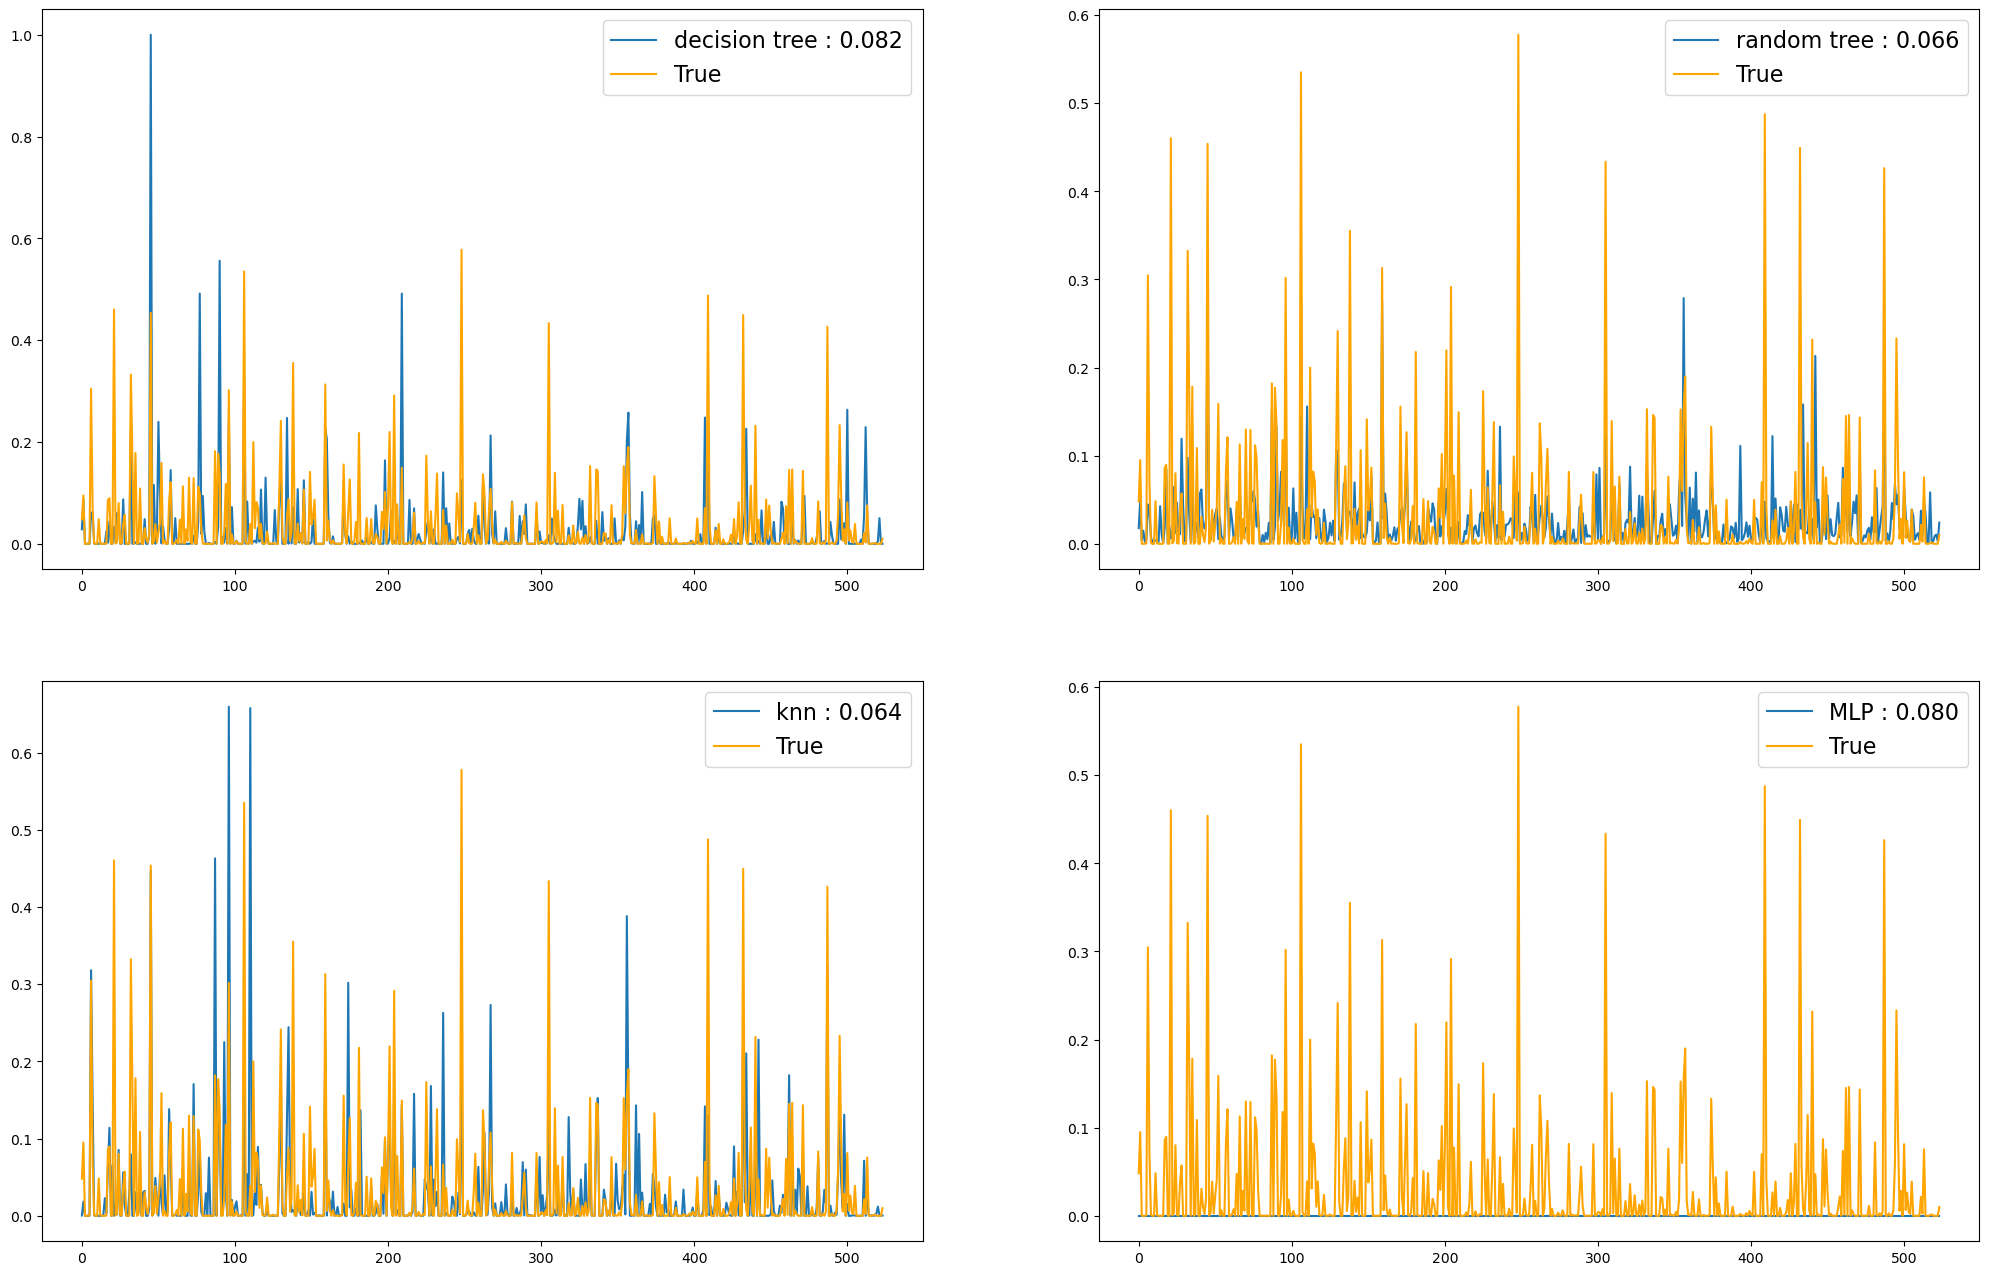

In [49]:
x = np.arange(len(y_test))

fig, ax = plt.subplots(2,2, figsize = (25,16))

# Plot the different model predictions and the real value
ax[0,0].plot(x, y_pred_decision_tree, label = f"decision tree : {np.mean(RMSE_decision_tree):.3f}")
ax[0,0].plot(x, y_test, 'k-', label="True", color="orange")
ax[1,0].plot(x, y_pred_knn, label = f"knn : {np.mean(RMSE_knn):.3f}")
ax[1,0].plot(x, y_test, 'k-', label="True", color="orange")
ax[0,1].plot(x, y_pred_random_forest, label = f"random tree : {np.mean(RMSE_random_forest):.3f}")
ax[0,1].plot(x, y_test, 'k-', label="True", color="orange")
ax[1,1].plot(x, y_pred_MLP, label = f"MLP : {np.mean(RMSE_MLP):.3f}")
ax[1,1].plot(x, y_test, 'k-', label="True", color="orange")

ax[0,0].legend(fontsize=16)
ax[1,0].legend(fontsize=16)
ax[0,1].legend(fontsize=16)
ax[1,1].legend(fontsize=16)
plt.savefig("grid_search.svg")
plt.show()

In [50]:
print("decision Tree: ",best_param_decision_tree, "\n")
print("KNN : ", best_param_knn, "\n")
print("Random Forest : ",best_param_random_forest)

decision Tree:  {'ccp_alpha': 0.0, 'criterion': 'poisson', 'max_features': 'log2', 'min_impurity_decrease': 0.0, 'min_samples_split': 2, 'random_state': 1, 'splitter': 'random'} 

KNN :  {'n_neighbors': 2} 

Random Forest :  {'criterion': 'poisson', 'max_features': 'log2', 'min_samples_split': 6}


In [51]:
print(np.mean(R2_decision_tree))
print(np.mean(R2_knn))
print(np.mean(R2_random_forest))
print(np.mean(R2_MLP))

-0.24020260249810996
0.251033838671451
0.19447849904240405
-0.17845691740615305


In [52]:
print(np.mean(RMSE_decision_tree))
print(np.mean(RMSE_knn))
print(np.mean(RMSE_random_forest))
print(np.mean(RMSE_MLP))

0.08202498100118476
0.06373278926883957
0.0663727608494608
0.08018795527308142


In [53]:
X_valid = pd.DataFrame(data=scaler.transform(X_valid), columns=X_valid.columns)
y_valid = pd.DataFrame(data=scaler_y.transform(y_valid), columns=y_valid.columns)

dtr = DecisionTreeRegressor(ccp_alpha= 0.0, criterion="poisson", max_features="log2", min_impurity_decrease=0.0, min_samples_split= 2, random_state=1, splitter="random")
dtr.fit(X_train_scaled, y_train_scaled)
dtr_preds = dtr.predict(X_valid)
RMSE_dtr, R2_dtr = compute_rmse(dtr_preds, y_valid.to_numpy()), r2_score(y_valid.to_numpy(), dtr_preds)

knn_val = KNeighborsRegressor(n_neighbors=2)
knn_val.fit(X_train_scaled, y_train_scaled)
knn_preds = knn_val.predict(X_valid)
RMSE_knn, R2_knn = compute_rmse(knn_preds, y_valid.to_numpy()), r2_score(y_valid.to_numpy(), knn_preds)

rf = RandomForestRegressor(criterion = 'poisson', max_features = 'sqrt', min_samples_split = 6)
rf.fit(X_train_scaled, y_train_scaled)
rf_preds = rf.predict(X_valid)
RMSE_rf, R2_rf = compute_rmse(rf_preds, y_valid.to_numpy()), r2_score(y_valid.to_numpy(), rf_preds)


print(RMSE_dtr, R2_dtr)
print(RMSE_knn, R2_knn)
print(RMSE_rf, R2_rf)



0.07664664778857393 0.0003118362548657494
0.06917505967457716 0.18571336941287964
0.06715408312929878 0.23259775151408524


# 5. Classification

In [54]:
X = df1.copy()
y = Y1.iloc[X["index"]]
X.drop(columns=["index"], inplace=True)
X_train_scaled, y_train_scaled, X_valid, y_valid, scaler, scaler_y = scaling_split_data(X, y, y_scaling=False)

In [55]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

y2 = y_train_scaled.copy()

y2[y > 1e7] = int(1)
y2[((y > 1e5) & (y < 1e7))] = int(0)
y2[y < 1e5] = int(-1)

enc = LabelEncoder()
y_enc = enc.fit_transform(y2)
cat_y = to_categorical(y_enc)

In [56]:
model = Sequential()
model.add(Dense(100, input_dim=X_train_scaled.shape[-1], activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), 
              metrics = "accuracy")

history = model.fit(X_train_scaled, cat_y, epochs=2000, batch_size=64, verbose=2, shuffle=False)
model.save("classification.h5")

Epoch 1/2000
41/41 - 0s - loss: 1.0412 - accuracy: 0.4355 - 206ms/epoch - 5ms/step
Epoch 2/2000
41/41 - 0s - loss: 0.9760 - accuracy: 0.5099 - 25ms/epoch - 608us/step
Epoch 3/2000
41/41 - 0s - loss: 0.9186 - accuracy: 0.5561 - 24ms/epoch - 590us/step
Epoch 4/2000
41/41 - 0s - loss: 0.8805 - accuracy: 0.5771 - 16ms/epoch - 381us/step
Epoch 5/2000
41/41 - 0s - loss: 0.8523 - accuracy: 0.5962 - 17ms/epoch - 421us/step
Epoch 6/2000
41/41 - 0s - loss: 0.8321 - accuracy: 0.6153 - 20ms/epoch - 491us/step
Epoch 7/2000
41/41 - 0s - loss: 0.8158 - accuracy: 0.6260 - 27ms/epoch - 662us/step
Epoch 8/2000
41/41 - 0s - loss: 0.8023 - accuracy: 0.6347 - 16ms/epoch - 381us/step
Epoch 9/2000
41/41 - 0s - loss: 0.7816 - accuracy: 0.6385 - 31ms/epoch - 762us/step
Epoch 10/2000
41/41 - 0s - loss: 0.7664 - accuracy: 0.6462 - 26ms/epoch - 637us/step
Epoch 11/2000
41/41 - 0s - loss: 0.7576 - accuracy: 0.6557 - 21ms/epoch - 515us/step
Epoch 12/2000
41/41 - 0s - loss: 0.7483 - accuracy: 0.6569 - 16ms/epoch - 3

Epoch 98/2000
41/41 - 0s - loss: 0.4742 - accuracy: 0.7687 - 27ms/epoch - 648us/step
Epoch 99/2000
41/41 - 0s - loss: 0.4918 - accuracy: 0.7706 - 26ms/epoch - 632us/step
Epoch 100/2000
41/41 - 0s - loss: 0.4829 - accuracy: 0.7691 - 26ms/epoch - 632us/step
Epoch 101/2000
41/41 - 0s - loss: 0.4770 - accuracy: 0.7588 - 26ms/epoch - 632us/step
Epoch 102/2000
41/41 - 0s - loss: 0.4669 - accuracy: 0.7794 - 26ms/epoch - 635us/step
Epoch 103/2000
41/41 - 0s - loss: 0.4569 - accuracy: 0.7821 - 27ms/epoch - 656us/step
Epoch 104/2000
41/41 - 0s - loss: 0.4520 - accuracy: 0.7805 - 26ms/epoch - 632us/step
Epoch 105/2000
41/41 - 0s - loss: 0.4401 - accuracy: 0.7847 - 26ms/epoch - 632us/step
Epoch 106/2000
41/41 - 0s - loss: 0.4497 - accuracy: 0.7836 - 27ms/epoch - 656us/step
Epoch 107/2000
41/41 - 0s - loss: 0.4468 - accuracy: 0.7760 - 29ms/epoch - 705us/step
Epoch 108/2000
41/41 - 0s - loss: 0.4345 - accuracy: 0.7866 - 26ms/epoch - 632us/step
Epoch 109/2000
41/41 - 0s - loss: 0.4420 - accuracy: 0.7

Epoch 194/2000
41/41 - 0s - loss: 0.3775 - accuracy: 0.8187 - 26ms/epoch - 632us/step
Epoch 195/2000
41/41 - 0s - loss: 0.3630 - accuracy: 0.8229 - 25ms/epoch - 608us/step
Epoch 196/2000
41/41 - 0s - loss: 0.3512 - accuracy: 0.8282 - 26ms/epoch - 632us/step
Epoch 197/2000
41/41 - 0s - loss: 0.3787 - accuracy: 0.8149 - 25ms/epoch - 608us/step
Epoch 198/2000
41/41 - 0s - loss: 0.4004 - accuracy: 0.8057 - 25ms/epoch - 604us/step
Epoch 199/2000
41/41 - 0s - loss: 0.4150 - accuracy: 0.8019 - 25ms/epoch - 607us/step
Epoch 200/2000
41/41 - 0s - loss: 0.3886 - accuracy: 0.8076 - 26ms/epoch - 632us/step
Epoch 201/2000
41/41 - 0s - loss: 0.3747 - accuracy: 0.8229 - 25ms/epoch - 608us/step
Epoch 202/2000
41/41 - 0s - loss: 0.4014 - accuracy: 0.8088 - 25ms/epoch - 607us/step
Epoch 203/2000
41/41 - 0s - loss: 0.4041 - accuracy: 0.8057 - 25ms/epoch - 607us/step
Epoch 204/2000
41/41 - 0s - loss: 0.3780 - accuracy: 0.8202 - 25ms/epoch - 607us/step
Epoch 205/2000
41/41 - 0s - loss: 0.3884 - accuracy: 0

Epoch 290/2000
41/41 - 0s - loss: 0.3559 - accuracy: 0.8336 - 25ms/epoch - 608us/step
Epoch 291/2000
41/41 - 0s - loss: 0.3110 - accuracy: 0.8477 - 25ms/epoch - 608us/step
Epoch 292/2000
41/41 - 0s - loss: 0.3436 - accuracy: 0.8462 - 24ms/epoch - 583us/step
Epoch 293/2000
41/41 - 0s - loss: 0.3133 - accuracy: 0.8466 - 25ms/epoch - 608us/step
Epoch 294/2000
41/41 - 0s - loss: 0.3023 - accuracy: 0.8538 - 25ms/epoch - 601us/step
Epoch 295/2000
41/41 - 0s - loss: 0.2920 - accuracy: 0.8573 - 25ms/epoch - 598us/step
Epoch 296/2000
41/41 - 0s - loss: 0.3028 - accuracy: 0.8481 - 26ms/epoch - 623us/step
Epoch 297/2000
41/41 - 0s - loss: 0.3342 - accuracy: 0.8412 - 27ms/epoch - 653us/step
Epoch 298/2000
41/41 - 0s - loss: 0.3696 - accuracy: 0.8240 - 28ms/epoch - 694us/step
Epoch 299/2000
41/41 - 0s - loss: 0.3331 - accuracy: 0.8469 - 42ms/epoch - 1ms/step
Epoch 300/2000
41/41 - 0s - loss: 0.3279 - accuracy: 0.8405 - 28ms/epoch - 687us/step
Epoch 301/2000
41/41 - 0s - loss: 0.3081 - accuracy: 0.8

Epoch 386/2000
41/41 - 0s - loss: 0.2888 - accuracy: 0.8679 - 28ms/epoch - 681us/step
Epoch 387/2000
41/41 - 0s - loss: 0.3471 - accuracy: 0.8588 - 28ms/epoch - 681us/step
Epoch 388/2000
41/41 - 0s - loss: 0.3333 - accuracy: 0.8508 - 28ms/epoch - 681us/step
Epoch 389/2000
41/41 - 0s - loss: 0.3896 - accuracy: 0.8378 - 28ms/epoch - 681us/step
Epoch 390/2000
41/41 - 0s - loss: 0.3925 - accuracy: 0.8340 - 28ms/epoch - 681us/step
Epoch 391/2000
41/41 - 0s - loss: 0.2954 - accuracy: 0.8580 - 28ms/epoch - 681us/step
Epoch 392/2000
41/41 - 0s - loss: 0.2813 - accuracy: 0.8740 - 29ms/epoch - 705us/step
Epoch 393/2000
41/41 - 0s - loss: 0.2732 - accuracy: 0.8672 - 28ms/epoch - 680us/step
Epoch 394/2000
41/41 - 0s - loss: 0.2466 - accuracy: 0.8794 - 27ms/epoch - 656us/step
Epoch 395/2000
41/41 - 0s - loss: 0.2355 - accuracy: 0.8882 - 28ms/epoch - 681us/step
Epoch 396/2000
41/41 - 0s - loss: 0.2324 - accuracy: 0.8844 - 29ms/epoch - 705us/step
Epoch 397/2000
41/41 - 0s - loss: 0.2502 - accuracy: 0

Epoch 482/2000
41/41 - 0s - loss: 0.2179 - accuracy: 0.9023 - 27ms/epoch - 656us/step
Epoch 483/2000
41/41 - 0s - loss: 0.2371 - accuracy: 0.8885 - 25ms/epoch - 608us/step
Epoch 484/2000
41/41 - 0s - loss: 0.2245 - accuracy: 0.8989 - 27ms/epoch - 656us/step
Epoch 485/2000
41/41 - 0s - loss: 0.2701 - accuracy: 0.8889 - 25ms/epoch - 608us/step
Epoch 486/2000
41/41 - 0s - loss: 0.2698 - accuracy: 0.8859 - 27ms/epoch - 656us/step
Epoch 487/2000
41/41 - 0s - loss: 0.2608 - accuracy: 0.8851 - 27ms/epoch - 656us/step
Epoch 488/2000
41/41 - 0s - loss: 0.3127 - accuracy: 0.8664 - 27ms/epoch - 656us/step
Epoch 489/2000
41/41 - 0s - loss: 0.3259 - accuracy: 0.8676 - 25ms/epoch - 607us/step
Epoch 490/2000
41/41 - 0s - loss: 0.3197 - accuracy: 0.8656 - 26ms/epoch - 632us/step
Epoch 491/2000
41/41 - 0s - loss: 0.3037 - accuracy: 0.8729 - 27ms/epoch - 656us/step
Epoch 492/2000
41/41 - 0s - loss: 0.2660 - accuracy: 0.8840 - 28ms/epoch - 686us/step
Epoch 493/2000
41/41 - 0s - loss: 0.2817 - accuracy: 0

Epoch 578/2000
41/41 - 0s - loss: 0.2013 - accuracy: 0.9099 - 32ms/epoch - 772us/step
Epoch 579/2000
41/41 - 0s - loss: 0.2238 - accuracy: 0.8989 - 16ms/epoch - 381us/step
Epoch 580/2000
41/41 - 0s - loss: 0.2097 - accuracy: 0.9126 - 31ms/epoch - 762us/step
Epoch 581/2000
41/41 - 0s - loss: 0.2095 - accuracy: 0.9053 - 31ms/epoch - 762us/step
Epoch 582/2000
41/41 - 0s - loss: 0.2449 - accuracy: 0.8897 - 16ms/epoch - 390us/step
Epoch 583/2000
41/41 - 0s - loss: 0.2572 - accuracy: 0.8901 - 31ms/epoch - 762us/step
Epoch 584/2000
41/41 - 0s - loss: 0.2889 - accuracy: 0.8805 - 16ms/epoch - 381us/step
Epoch 585/2000
41/41 - 0s - loss: 0.3122 - accuracy: 0.8634 - 16ms/epoch - 381us/step
Epoch 586/2000
41/41 - 0s - loss: 0.3246 - accuracy: 0.8687 - 32ms/epoch - 771us/step
Epoch 587/2000
41/41 - 0s - loss: 0.2513 - accuracy: 0.8855 - 16ms/epoch - 381us/step
Epoch 588/2000
41/41 - 0s - loss: 0.2272 - accuracy: 0.8958 - 16ms/epoch - 381us/step
Epoch 589/2000
41/41 - 0s - loss: 0.2160 - accuracy: 0

Epoch 674/2000
41/41 - 0s - loss: 0.1785 - accuracy: 0.9187 - 26ms/epoch - 632us/step
Epoch 675/2000
41/41 - 0s - loss: 0.1731 - accuracy: 0.9218 - 27ms/epoch - 648us/step
Epoch 676/2000
41/41 - 0s - loss: 0.1957 - accuracy: 0.9134 - 25ms/epoch - 608us/step
Epoch 677/2000
41/41 - 0s - loss: 0.2036 - accuracy: 0.9099 - 25ms/epoch - 608us/step
Epoch 678/2000
41/41 - 0s - loss: 0.2265 - accuracy: 0.8989 - 26ms/epoch - 632us/step
Epoch 679/2000
41/41 - 0s - loss: 0.2474 - accuracy: 0.8973 - 25ms/epoch - 608us/step
Epoch 680/2000
41/41 - 0s - loss: 0.2928 - accuracy: 0.8832 - 25ms/epoch - 608us/step
Epoch 681/2000
41/41 - 0s - loss: 0.2885 - accuracy: 0.8771 - 26ms/epoch - 632us/step
Epoch 682/2000
41/41 - 0s - loss: 0.3612 - accuracy: 0.8561 - 26ms/epoch - 632us/step
Epoch 683/2000
41/41 - 0s - loss: 0.3858 - accuracy: 0.8511 - 28ms/epoch - 682us/step
Epoch 684/2000
41/41 - 0s - loss: 0.2784 - accuracy: 0.8760 - 27ms/epoch - 656us/step
Epoch 685/2000
41/41 - 0s - loss: 0.2205 - accuracy: 0

Epoch 770/2000
41/41 - 0s - loss: 0.3165 - accuracy: 0.8714 - 24ms/epoch - 583us/step
Epoch 771/2000
41/41 - 0s - loss: 0.2625 - accuracy: 0.8878 - 24ms/epoch - 583us/step
Epoch 772/2000
41/41 - 0s - loss: 0.2469 - accuracy: 0.8962 - 24ms/epoch - 583us/step
Epoch 773/2000
41/41 - 0s - loss: 0.2153 - accuracy: 0.9057 - 24ms/epoch - 583us/step
Epoch 774/2000
41/41 - 0s - loss: 0.2140 - accuracy: 0.9019 - 23ms/epoch - 559us/step
Epoch 775/2000
41/41 - 0s - loss: 0.2060 - accuracy: 0.9065 - 24ms/epoch - 583us/step
Epoch 776/2000
41/41 - 0s - loss: 0.1759 - accuracy: 0.9179 - 22ms/epoch - 544us/step
Epoch 777/2000
41/41 - 0s - loss: 0.1716 - accuracy: 0.9210 - 16ms/epoch - 381us/step
Epoch 778/2000
41/41 - 0s - loss: 0.1778 - accuracy: 0.9141 - 39ms/epoch - 962us/step
Epoch 779/2000
41/41 - 0s - loss: 0.1952 - accuracy: 0.9153 - 25ms/epoch - 608us/step
Epoch 780/2000
41/41 - 0s - loss: 0.1839 - accuracy: 0.9225 - 27ms/epoch - 663us/step
Epoch 781/2000
41/41 - 0s - loss: 0.1740 - accuracy: 0

Epoch 866/2000
41/41 - 0s - loss: 0.1583 - accuracy: 0.9336 - 26ms/epoch - 632us/step
Epoch 867/2000
41/41 - 0s - loss: 0.1687 - accuracy: 0.9298 - 26ms/epoch - 632us/step
Epoch 868/2000
41/41 - 0s - loss: 0.1600 - accuracy: 0.9260 - 26ms/epoch - 632us/step
Epoch 869/2000
41/41 - 0s - loss: 0.1525 - accuracy: 0.9305 - 26ms/epoch - 632us/step
Epoch 870/2000
41/41 - 0s - loss: 0.1538 - accuracy: 0.9313 - 26ms/epoch - 632us/step
Epoch 871/2000
41/41 - 0s - loss: 0.1591 - accuracy: 0.9275 - 26ms/epoch - 634us/step
Epoch 872/2000
41/41 - 0s - loss: 0.1565 - accuracy: 0.9317 - 26ms/epoch - 632us/step
Epoch 873/2000
41/41 - 0s - loss: 0.1678 - accuracy: 0.9275 - 27ms/epoch - 656us/step
Epoch 874/2000
41/41 - 0s - loss: 0.2167 - accuracy: 0.9084 - 26ms/epoch - 632us/step
Epoch 875/2000
41/41 - 0s - loss: 0.1888 - accuracy: 0.9195 - 25ms/epoch - 607us/step
Epoch 876/2000
41/41 - 0s - loss: 0.1848 - accuracy: 0.9221 - 26ms/epoch - 632us/step
Epoch 877/2000
41/41 - 0s - loss: 0.1841 - accuracy: 0

Epoch 962/2000
41/41 - 0s - loss: 0.1723 - accuracy: 0.9244 - 31ms/epoch - 754us/step
Epoch 963/2000
41/41 - 0s - loss: 0.1510 - accuracy: 0.9309 - 32ms/epoch - 778us/step
Epoch 964/2000
41/41 - 0s - loss: 0.1474 - accuracy: 0.9344 - 30ms/epoch - 729us/step
Epoch 965/2000
41/41 - 0s - loss: 0.1392 - accuracy: 0.9405 - 34ms/epoch - 821us/step
Epoch 966/2000
41/41 - 0s - loss: 0.1390 - accuracy: 0.9408 - 43ms/epoch - 1ms/step
Epoch 967/2000
41/41 - 0s - loss: 0.1332 - accuracy: 0.9397 - 32ms/epoch - 779us/step
Epoch 968/2000
41/41 - 0s - loss: 0.1346 - accuracy: 0.9397 - 29ms/epoch - 717us/step
Epoch 969/2000
41/41 - 0s - loss: 0.1471 - accuracy: 0.9351 - 29ms/epoch - 707us/step
Epoch 970/2000
41/41 - 0s - loss: 0.1564 - accuracy: 0.9294 - 29ms/epoch - 705us/step
Epoch 971/2000
41/41 - 0s - loss: 0.1957 - accuracy: 0.9195 - 29ms/epoch - 697us/step
Epoch 972/2000
41/41 - 0s - loss: 0.2475 - accuracy: 0.9099 - 30ms/epoch - 721us/step
Epoch 973/2000
41/41 - 0s - loss: 0.2237 - accuracy: 0.9

Epoch 1057/2000
41/41 - 0s - loss: 0.1944 - accuracy: 0.9141 - 25ms/epoch - 608us/step
Epoch 1058/2000
41/41 - 0s - loss: 0.1614 - accuracy: 0.9271 - 27ms/epoch - 656us/step
Epoch 1059/2000
41/41 - 0s - loss: 0.1474 - accuracy: 0.9324 - 25ms/epoch - 608us/step
Epoch 1060/2000
41/41 - 0s - loss: 0.1406 - accuracy: 0.9351 - 24ms/epoch - 592us/step
Epoch 1061/2000
41/41 - 0s - loss: 0.1381 - accuracy: 0.9359 - 16ms/epoch - 381us/step
Epoch 1062/2000
41/41 - 0s - loss: 0.1369 - accuracy: 0.9389 - 36ms/epoch - 890us/step
Epoch 1063/2000
41/41 - 0s - loss: 0.1428 - accuracy: 0.9328 - 26ms/epoch - 632us/step
Epoch 1064/2000
41/41 - 0s - loss: 0.1433 - accuracy: 0.9363 - 26ms/epoch - 630us/step
Epoch 1065/2000
41/41 - 0s - loss: 0.1451 - accuracy: 0.9328 - 26ms/epoch - 632us/step
Epoch 1066/2000
41/41 - 0s - loss: 0.1600 - accuracy: 0.9328 - 25ms/epoch - 608us/step
Epoch 1067/2000
41/41 - 0s - loss: 0.1514 - accuracy: 0.9313 - 25ms/epoch - 608us/step
Epoch 1068/2000
41/41 - 0s - loss: 0.1678 -

41/41 - 0s - loss: 0.1689 - accuracy: 0.9263 - 32ms/epoch - 771us/step
Epoch 1152/2000
41/41 - 0s - loss: 0.1448 - accuracy: 0.9378 - 31ms/epoch - 762us/step
Epoch 1153/2000
41/41 - 0s - loss: 0.1342 - accuracy: 0.9416 - 28ms/epoch - 674us/step
Epoch 1154/2000
41/41 - 0s - loss: 0.1271 - accuracy: 0.9466 - 24ms/epoch - 577us/step
Epoch 1155/2000
41/41 - 0s - loss: 0.1217 - accuracy: 0.9473 - 16ms/epoch - 390us/step
Epoch 1156/2000
41/41 - 0s - loss: 0.1150 - accuracy: 0.9538 - 32ms/epoch - 771us/step
Epoch 1157/2000
41/41 - 0s - loss: 0.1114 - accuracy: 0.9519 - 16ms/epoch - 381us/step
Epoch 1158/2000
41/41 - 0s - loss: 0.1220 - accuracy: 0.9466 - 31ms/epoch - 762us/step
Epoch 1159/2000
41/41 - 0s - loss: 0.1174 - accuracy: 0.9496 - 16ms/epoch - 390us/step
Epoch 1160/2000
41/41 - 0s - loss: 0.1299 - accuracy: 0.9389 - 16ms/epoch - 381us/step
Epoch 1161/2000
41/41 - 0s - loss: 0.1475 - accuracy: 0.9374 - 31ms/epoch - 762us/step
Epoch 1162/2000
41/41 - 0s - loss: 0.1342 - accuracy: 0.941

Epoch 1246/2000
41/41 - 0s - loss: 0.2271 - accuracy: 0.9057 - 25ms/epoch - 608us/step
Epoch 1247/2000
41/41 - 0s - loss: 0.1740 - accuracy: 0.9271 - 25ms/epoch - 608us/step
Epoch 1248/2000
41/41 - 0s - loss: 0.1678 - accuracy: 0.9256 - 25ms/epoch - 618us/step
Epoch 1249/2000
41/41 - 0s - loss: 0.1491 - accuracy: 0.9309 - 27ms/epoch - 665us/step
Epoch 1250/2000
41/41 - 0s - loss: 0.1256 - accuracy: 0.9469 - 27ms/epoch - 656us/step
Epoch 1251/2000
41/41 - 0s - loss: 0.1194 - accuracy: 0.9473 - 26ms/epoch - 632us/step
Epoch 1252/2000
41/41 - 0s - loss: 0.1140 - accuracy: 0.9469 - 25ms/epoch - 608us/step
Epoch 1253/2000
41/41 - 0s - loss: 0.1087 - accuracy: 0.9508 - 25ms/epoch - 608us/step
Epoch 1254/2000
41/41 - 0s - loss: 0.1221 - accuracy: 0.9485 - 26ms/epoch - 632us/step
Epoch 1255/2000
41/41 - 0s - loss: 0.1205 - accuracy: 0.9447 - 25ms/epoch - 608us/step
Epoch 1256/2000
41/41 - 0s - loss: 0.1115 - accuracy: 0.9519 - 26ms/epoch - 624us/step
Epoch 1257/2000
41/41 - 0s - loss: 0.1135 -

Epoch 1341/2000
41/41 - 0s - loss: 0.1480 - accuracy: 0.9370 - 29ms/epoch - 705us/step
Epoch 1342/2000
41/41 - 0s - loss: 0.1237 - accuracy: 0.9477 - 28ms/epoch - 681us/step
Epoch 1343/2000
41/41 - 0s - loss: 0.1162 - accuracy: 0.9473 - 28ms/epoch - 681us/step
Epoch 1344/2000
41/41 - 0s - loss: 0.1076 - accuracy: 0.9511 - 28ms/epoch - 681us/step
Epoch 1345/2000
41/41 - 0s - loss: 0.1149 - accuracy: 0.9450 - 29ms/epoch - 705us/step
Epoch 1346/2000
41/41 - 0s - loss: 0.1082 - accuracy: 0.9531 - 28ms/epoch - 681us/step
Epoch 1347/2000
41/41 - 0s - loss: 0.1033 - accuracy: 0.9553 - 29ms/epoch - 714us/step
Epoch 1348/2000
41/41 - 0s - loss: 0.1045 - accuracy: 0.9561 - 27ms/epoch - 656us/step
Epoch 1349/2000
41/41 - 0s - loss: 0.1074 - accuracy: 0.9592 - 25ms/epoch - 608us/step
Epoch 1350/2000
41/41 - 0s - loss: 0.1279 - accuracy: 0.9462 - 26ms/epoch - 632us/step
Epoch 1351/2000
41/41 - 0s - loss: 0.1237 - accuracy: 0.9420 - 17ms/epoch - 417us/step
Epoch 1352/2000
41/41 - 0s - loss: 0.1150 -

Epoch 1436/2000
41/41 - 0s - loss: 0.1304 - accuracy: 0.9447 - 27ms/epoch - 665us/step
Epoch 1437/2000
41/41 - 0s - loss: 0.1447 - accuracy: 0.9427 - 27ms/epoch - 665us/step
Epoch 1438/2000
41/41 - 0s - loss: 0.1150 - accuracy: 0.9546 - 28ms/epoch - 686us/step
Epoch 1439/2000
41/41 - 0s - loss: 0.1048 - accuracy: 0.9557 - 28ms/epoch - 693us/step
Epoch 1440/2000
41/41 - 0s - loss: 0.1101 - accuracy: 0.9534 - 29ms/epoch - 699us/step
Epoch 1441/2000
41/41 - 0s - loss: 0.1030 - accuracy: 0.9557 - 28ms/epoch - 672us/step
Epoch 1442/2000
41/41 - 0s - loss: 0.1078 - accuracy: 0.9504 - 28ms/epoch - 674us/step
Epoch 1443/2000
41/41 - 0s - loss: 0.0985 - accuracy: 0.9592 - 26ms/epoch - 636us/step
Epoch 1444/2000
41/41 - 0s - loss: 0.1170 - accuracy: 0.9454 - 29ms/epoch - 701us/step
Epoch 1445/2000
41/41 - 0s - loss: 0.1249 - accuracy: 0.9462 - 29ms/epoch - 713us/step
Epoch 1446/2000
41/41 - 0s - loss: 0.1487 - accuracy: 0.9393 - 28ms/epoch - 680us/step
Epoch 1447/2000
41/41 - 0s - loss: 0.1765 -

41/41 - 0s - loss: 0.0972 - accuracy: 0.9565 - 26ms/epoch - 632us/step
Epoch 1531/2000
41/41 - 0s - loss: 0.0921 - accuracy: 0.9580 - 28ms/epoch - 683us/step
Epoch 1532/2000
41/41 - 0s - loss: 0.0978 - accuracy: 0.9588 - 27ms/epoch - 656us/step
Epoch 1533/2000
41/41 - 0s - loss: 0.1173 - accuracy: 0.9515 - 25ms/epoch - 609us/step
Epoch 1534/2000
41/41 - 0s - loss: 0.1032 - accuracy: 0.9580 - 27ms/epoch - 656us/step
Epoch 1535/2000
41/41 - 0s - loss: 0.1193 - accuracy: 0.9443 - 25ms/epoch - 611us/step
Epoch 1536/2000
41/41 - 0s - loss: 0.1306 - accuracy: 0.9435 - 25ms/epoch - 608us/step
Epoch 1537/2000
41/41 - 0s - loss: 0.1759 - accuracy: 0.9286 - 26ms/epoch - 632us/step
Epoch 1538/2000
41/41 - 0s - loss: 0.1815 - accuracy: 0.9309 - 26ms/epoch - 632us/step
Epoch 1539/2000
41/41 - 0s - loss: 0.1725 - accuracy: 0.9294 - 25ms/epoch - 608us/step
Epoch 1540/2000
41/41 - 0s - loss: 0.1992 - accuracy: 0.9290 - 28ms/epoch - 681us/step
Epoch 1541/2000
41/41 - 0s - loss: 0.2881 - accuracy: 0.894

Epoch 1625/2000
41/41 - 0s - loss: 0.0942 - accuracy: 0.9653 - 34ms/epoch - 827us/step
Epoch 1626/2000
41/41 - 0s - loss: 0.0980 - accuracy: 0.9595 - 35ms/epoch - 844us/step
Epoch 1627/2000
41/41 - 0s - loss: 0.0979 - accuracy: 0.9573 - 31ms/epoch - 762us/step
Epoch 1628/2000
41/41 - 0s - loss: 0.0917 - accuracy: 0.9599 - 47ms/epoch - 1ms/step
Epoch 1629/2000
41/41 - 0s - loss: 0.0980 - accuracy: 0.9622 - 34ms/epoch - 830us/step
Epoch 1630/2000
41/41 - 0s - loss: 0.1001 - accuracy: 0.9561 - 32ms/epoch - 792us/step
Epoch 1631/2000
41/41 - 0s - loss: 0.0925 - accuracy: 0.9611 - 32ms/epoch - 772us/step
Epoch 1632/2000
41/41 - 0s - loss: 0.0937 - accuracy: 0.9599 - 31ms/epoch - 762us/step
Epoch 1633/2000
41/41 - 0s - loss: 0.0897 - accuracy: 0.9595 - 31ms/epoch - 762us/step
Epoch 1634/2000
41/41 - 0s - loss: 0.0931 - accuracy: 0.9603 - 19ms/epoch - 455us/step
Epoch 1635/2000
41/41 - 0s - loss: 0.1020 - accuracy: 0.9573 - 31ms/epoch - 762us/step
Epoch 1636/2000
41/41 - 0s - loss: 0.1182 - a

Epoch 1720/2000
41/41 - 0s - loss: 0.1602 - accuracy: 0.9447 - 31ms/epoch - 747us/step
Epoch 1721/2000
41/41 - 0s - loss: 0.1730 - accuracy: 0.9401 - 31ms/epoch - 762us/step
Epoch 1722/2000
41/41 - 0s - loss: 0.1356 - accuracy: 0.9489 - 38ms/epoch - 933us/step
Epoch 1723/2000
41/41 - 0s - loss: 0.1036 - accuracy: 0.9592 - 25ms/epoch - 601us/step
Epoch 1724/2000
41/41 - 0s - loss: 0.0912 - accuracy: 0.9664 - 31ms/epoch - 762us/step
Epoch 1725/2000
41/41 - 0s - loss: 0.1101 - accuracy: 0.9553 - 31ms/epoch - 762us/step
Epoch 1726/2000
41/41 - 0s - loss: 0.1917 - accuracy: 0.9267 - 32ms/epoch - 772us/step
Epoch 1727/2000
41/41 - 0s - loss: 0.1647 - accuracy: 0.9286 - 16ms/epoch - 381us/step
Epoch 1728/2000
41/41 - 0s - loss: 0.1281 - accuracy: 0.9508 - 31ms/epoch - 762us/step
Epoch 1729/2000
41/41 - 0s - loss: 0.1524 - accuracy: 0.9397 - 35ms/epoch - 847us/step
Epoch 1730/2000
41/41 - 0s - loss: 0.1321 - accuracy: 0.9427 - 28ms/epoch - 686us/step
Epoch 1731/2000
41/41 - 0s - loss: 0.1093 -

41/41 - 0s - loss: 0.0743 - accuracy: 0.9687 - 33ms/epoch - 795us/step
Epoch 1815/2000
41/41 - 0s - loss: 0.0756 - accuracy: 0.9679 - 29ms/epoch - 705us/step
Epoch 1816/2000
41/41 - 0s - loss: 0.0756 - accuracy: 0.9710 - 27ms/epoch - 669us/step
Epoch 1817/2000
41/41 - 0s - loss: 0.0734 - accuracy: 0.9660 - 26ms/epoch - 626us/step
Epoch 1818/2000
41/41 - 0s - loss: 0.0739 - accuracy: 0.9672 - 27ms/epoch - 667us/step
Epoch 1819/2000
41/41 - 0s - loss: 0.0782 - accuracy: 0.9687 - 27ms/epoch - 649us/step
Epoch 1820/2000
41/41 - 0s - loss: 0.1412 - accuracy: 0.9504 - 31ms/epoch - 766us/step
Epoch 1821/2000
41/41 - 0s - loss: 0.2924 - accuracy: 0.9080 - 22ms/epoch - 529us/step
Epoch 1822/2000
41/41 - 0s - loss: 0.3425 - accuracy: 0.8916 - 26ms/epoch - 634us/step
Epoch 1823/2000
41/41 - 0s - loss: 0.3457 - accuracy: 0.8855 - 26ms/epoch - 632us/step
Epoch 1824/2000
41/41 - 0s - loss: 0.2447 - accuracy: 0.9046 - 26ms/epoch - 641us/step
Epoch 1825/2000
41/41 - 0s - loss: 0.1470 - accuracy: 0.938

Epoch 1909/2000
41/41 - 0s - loss: 0.1947 - accuracy: 0.9332 - 26ms/epoch - 640us/step
Epoch 1910/2000
41/41 - 0s - loss: 0.2457 - accuracy: 0.9176 - 19ms/epoch - 451us/step
Epoch 1911/2000
41/41 - 0s - loss: 0.1869 - accuracy: 0.9344 - 33ms/epoch - 795us/step
Epoch 1912/2000
41/41 - 0s - loss: 0.2089 - accuracy: 0.9332 - 26ms/epoch - 625us/step
Epoch 1913/2000
41/41 - 0s - loss: 0.1920 - accuracy: 0.9271 - 25ms/epoch - 619us/step
Epoch 1914/2000
41/41 - 0s - loss: 0.1873 - accuracy: 0.9309 - 32ms/epoch - 780us/step
Epoch 1915/2000
41/41 - 0s - loss: 0.1087 - accuracy: 0.9542 - 18ms/epoch - 450us/step
Epoch 1916/2000
41/41 - 0s - loss: 0.0781 - accuracy: 0.9721 - 25ms/epoch - 619us/step
Epoch 1917/2000
41/41 - 0s - loss: 0.0709 - accuracy: 0.9718 - 27ms/epoch - 664us/step
Epoch 1918/2000
41/41 - 0s - loss: 0.0653 - accuracy: 0.9737 - 29ms/epoch - 707us/step
Epoch 1919/2000
41/41 - 0s - loss: 0.0657 - accuracy: 0.9740 - 20ms/epoch - 495us/step
Epoch 1920/2000
41/41 - 0s - loss: 0.0665 -

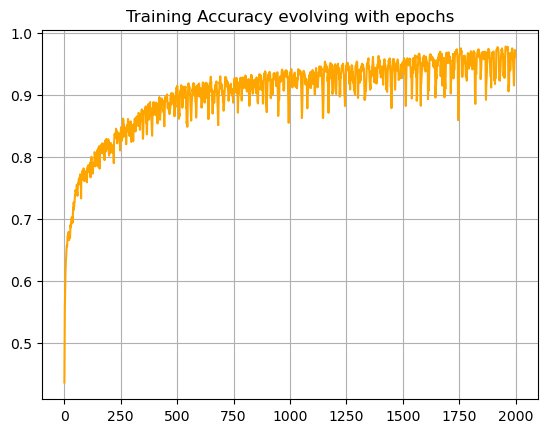

In [57]:
plt.plot(history.epoch, history.history["accuracy"], color="orange")
plt.grid()
plt.title("Training Accuracy evolving with epochs")
plt.savefig("classification.svg")
plt.show()

In [58]:
class_model = keras.models.load_model("classification.h5")

In [59]:
X_valid_scaled = pd.DataFrame(data=scaler.transform(X_valid), columns=X_valid.columns)

In [60]:
import tensorflow as tf

# Completely New data
y_val_enc = y_valid.copy()

y_val_enc[y_valid > 1e7] = int(1)
y_val_enc[((y_valid > 1e5) & (y_valid < 1e7))] = int(0)
y_val_enc[y_valid < 1e5] = int(-1)

enc_val = LabelEncoder()
y_val_enc = enc_val.fit_transform(y_val_enc)
cat_y_val = to_categorical(y_val_enc)

y_preds = cat_y_val.copy()

for i in range(len(y_preds)) :
    x = tf.convert_to_tensor(X_valid_scaled.iloc[i].values.reshape(1, X_valid_scaled.shape[-1]), dtype=tf.int64) 
    y_preds[i] = class_model.predict(x)

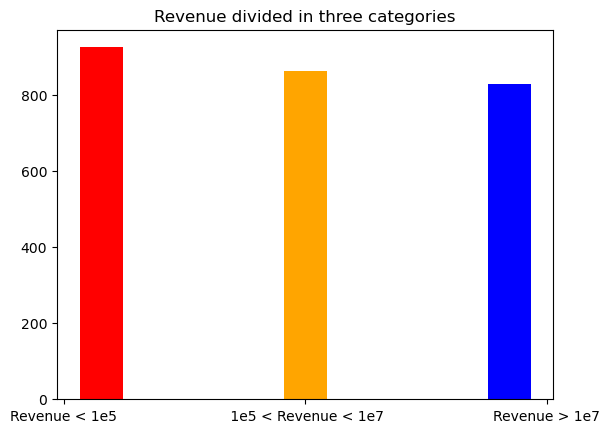

In [61]:
dic = {1.0 : "Revenue > 1e7", 0.0 : " 1e5 < Revenue < 1e7", -1.0 : "Revenue < 1e5"}
y_tmp = y2["revenue"].map(dic)
counts, edges, bars = plt.hist([y_tmp[y_tmp == "Revenue < 1e5"], y_tmp[y_tmp == " 1e5 < Revenue < 1e7"], y_tmp[y_tmp == "Revenue > 1e7"]], color=["red", "orange", "blue"], bins=3)
plt.title("Revenue divided in three categories")
plt.savefig("revenue_disc.svg")
plt.show()

In [62]:
accuracy = 0.0
for i in range(len(cat_y_val)) :
    accuracy += (np.argmax(cat_y_val[i]) == np.argmax(y_preds[i]))

accuracy /= len(cat_y_val)

print(f"Accuracy on the valid set is {accuracy:.3f}")

Accuracy on the valid set is 0.282


# 5. Dataset Augmentation

In [71]:
data = pd.read_csv("movies.csv")
data.dropna(inplace=True)
data = data[["year", "released", "score", "votes", "gross", "runtime"]]

for i in range(len(data)) :
    try :
        data["released"].iloc[i] = float(data["released"].iloc[i].split("(")[0].split(",")[-1].replace(" ", ""))
    except :
        data["released"].iloc[i] = np.nan

data.rename(columns = {'year':'production_year', 'released' : 'release_year', 'votes':'n_votes', 'gross' : 'revenue', 'score' : 'ratings'}, inplace = True)
data.dropna(inplace=True)
data

,production_year,release_year,ratings,n_votes,revenue,runtime
0,1980,1980.0,8.4,927000.0,46998772.0,146.0
1,1980,1980.0,5.8,65000.0,58853106.0,104.0
2,1980,1980.0,8.7,1200000.0,538375067.0,124.0
3,1980,1980.0,7.7,221000.0,83453539.0,88.0
4,1980,1980.0,7.3,108000.0,39846344.0,98.0
...,...,...,...,...,...,...
7648,2020,2020.0,6.6,140000.0,426505244.0,124.0
7649,2020,2020.0,6.5,102000.0,319715683.0,99.0
7650,2020,2020.0,5.6,53000.0,245487753.0,101.0
7651,2020,2020.0,6.8,42000.0,111105497.0,100.0


In [72]:
data.drop(columns="revenue", inplace=True)
new_X_train = pd.DataFrame(data=scaler.inverse_transform(X_train_scaled), columns=X_train_scaled.columns)
new_y_train = pd.DataFrame(data=scaler_y.inverse_transform(y_train_scaled), columns=y_train_scaled.columns)
base_y = Y1.iloc[df1["index"]]

df2 = pd.concat([data, new_X_train[["ratings", "n_votes", "production_year", "runtime", "release_year"]]])
Y_f = pd.concat([augm_y, new_y_train])

In [76]:
from sklearn.metrics import r2_score

X_train_scaled_aug, y_train_scaled_aug, X_valid_aug, y_valid_aug, scaler_aug, scaler_y_aug = scaling_split_data(df2, Y_f)


kf = KFold(shuffle = True)

RMSE_decision_tree_aug = list()
RMSE_knn_aug           = list()
RMSE_random_forest_aug = list()
RMSE_MLP_aug           = list()

R2_decision_tree_aug   = list()
R2_knn_aug             = list()
R2_random_forest_aug   = list()
R2_MLP_aug             = list()

old_r2_decision_tree_aug = -np.inf
old_r2_knn_aug           = -np.inf
old_r2_random_forest_aug = -np.inf

for train_index, test_index in kf.split(X_train_scaled_aug):

    X_train, X_test = X_train_scaled_aug.iloc[train_index], X_train_scaled_aug.iloc[test_index]
    y_train, y_test = y_train_scaled_aug.iloc[train_index], y_train_scaled_aug.iloc[test_index]
        
    #Predictions
    y_pred_decision_tree_aug, best_param_decision_tree_aug = pred_with_decision_tree(X_train, y_train, X_test)
    y_pred_knn_aug,           best_param_knn_aug           = pred_with_knn(X_train, y_train, X_test)
    y_pred_random_forest_aug, best_param_random_forest_aug = pred_with_random_forest(X_train, y_train, X_test)
    y_pred_MLP_aug,           history_aug                  = pred_with_NN(X_train, y_train, X_test, y_test)
    
    #Compute RMSE
    RMSE_decision_tree_aug.append(compute_rmse(y_pred_decision_tree_aug, y_test.to_numpy()))
    RMSE_knn_aug.append(          compute_rmse(y_pred_knn_aug,           y_test.to_numpy()))
    RMSE_random_forest_aug.append(compute_rmse(y_pred_random_forest_aug, y_test.to_numpy()))
    RMSE_MLP_aug.append(          compute_rmse(y_pred_MLP_aug,           y_test.to_numpy()))

    
    #Compute regression scores
    r2_decision_tree_aug = r2_score(y_test.to_numpy(), y_pred_decision_tree_aug)
    r2_knn_aug           = r2_score(y_test.to_numpy(), y_pred_knn_aug)
    r2_random_forest_aug = r2_score(y_test.to_numpy(), y_pred_random_forest_aug)
    r2_MLP_aug           = r2_score(y_test.to_numpy(), y_pred_MLP_aug)
    
    #Store the best parameters
    if(r2_decision_tree_aug > old_r2_decision_tree_aug) :
        param_decision_tree_aug = best_param_decision_tree_aug
        old_r2_decision_tree_aug = r2_decision_tree_aug
        
    if(r2_knn_aug > old_r2_knn_aug) :
        param_knn_aug = best_param_knn_aug
        old_r2_knn_aug = r2_knn_aug
        
    if(r2_random_forest_aug > old_r2_random_forest_aug) :
        param_random_forest_aug = best_param_random_forest_aug
        old_r2_random_forest_aug = r2_random_forest_aug
        
    R2_decision_tree_aug.append(r2_decision_tree_aug)
    R2_knn_aug.append(          r2_knn_aug)
    R2_random_forest_aug.append(r2_random_forest_aug)
    R2_MLP_aug.append(          r2_MLP_aug)

In [77]:
print(np.mean(R2_decision_tree_aug))
print(np.mean(R2_knn_aug))
print(np.mean(R2_random_forest_aug))
print(np.mean(R2_MLP_aug))

0.013950388061724817
0.3646576992677679
0.2906180647859191
-0.2718498883277841


In [78]:
print(np.mean(RMSE_decision_tree_aug))
print(np.mean(RMSE_knn_aug))
print(np.mean(RMSE_random_forest_aug))
print(np.mean(RMSE_MLP_aug))

0.06131575076748798
0.04924685796638154
0.052028485821808614
0.06962464406812861


In [ ]:
x = np.arange(len(y_test))

fig, ax = plt.subplots(2,2, figsize = (30,16))

# Plot the different model predictions and the real value
ax[0,0].plot(x, y_pred_decision_tree_aug, label = f"decision tree : {np.mean(RMSE_decision_tree_aug):.3f}")
ax[0,0].plot(x, y_test, 'k-', label="True", color="orange")
ax[1,0].plot(x, y_pred_knn_aug, label = f"knn : {np.mean(RMSE_knn_aug):.3f}")
ax[1,0].plot(x, y_test, 'k-', label="True", color="orange")
ax[0,1].plot(x, y_pred_random_forest_aug, label = f"random tree : {np.mean(RMSE_random_forest_aug):.3f}")
ax[0,1].plot(x, y_test, 'k-', label="True", color="orange")
ax[1,1].plot(x, y_pred_MLP_aug, label = f"MLP : {np.mean(RMSE_MLP_aug):.3f}")
ax[1,1].plot(x, y_test, 'k-', label="True", color="orange")

ax[0,0].legend(fontsize=16)
ax[1,0].legend(fontsize=16)
ax[0,1].legend(fontsize=16)
ax[1,1].legend(fontsize=16)
plt.savefig("grid_search_aug.svg")
plt.show()

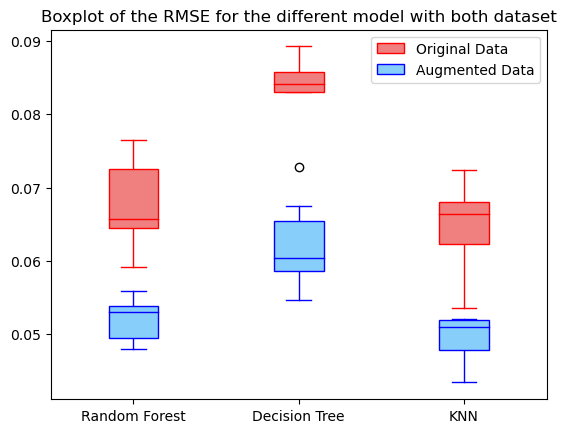

In [115]:
import matplotlib.pyplot as plt

def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp
    
example_data1 = [RMSE_random_forest, RMSE_decision_tree, RMSE_knn]
example_data2 = [RMSE_random_forest_aug, RMSE_decision_tree_aug, RMSE_knn_aug]

fig, ax = plt.subplots()
bp1 = box_plot(example_data1, 'red', 'lightcoral')
bp2 = box_plot(example_data2, 'blue', 'lightskyblue')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Original Data', 'Augmented Data'])
#ax.set_ylim(0, 10)
plt.title("Boxplot of the RMSE for the different model with both dataset")
plt.xticks([1, 2, 3], ["Random Forest", "Decision Tree", "KNN"])
plt.savefig("Boxplot_RMSE.svg")
plt.show()

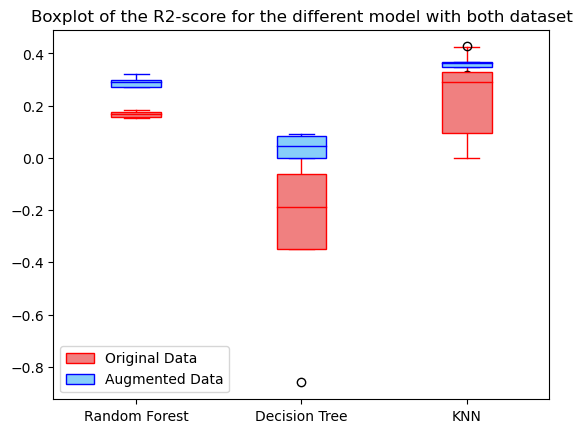

In [116]:
import matplotlib.pyplot as plt

def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp
    
example_data1 = [R2_random_forest, R2_decision_tree, R2_knn]
example_data2 = [R2_random_forest_aug, R2_decision_tree_aug, R2_knn_aug]

fig, ax = plt.subplots()
bp1 = box_plot(example_data1, 'red', 'lightcoral')
bp2 = box_plot(example_data2, 'blue', 'lightskyblue')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Original Data', 'Augmented Data'])
#ax.set_ylim(0, 10)
plt.title("Boxplot of the R2-score for the different model with both dataset")
plt.xticks([1, 2, 3], ["Random Forest", "Decision Tree", "KNN"])
plt.savefig("Boxplot_R2.svg")
plt.show()

In [ ]:
X_valid = pd.DataFrame(data=scaler.transform(X_valid), columns=X_valid.columns)
y_valid = pd.DataFrame(data=scaler_y.transform(y_valid), columns=y_valid.columns)

dtr = DecisionTreeRegressor(ccp_alpha= 0.0, criterion="poisson", max_features="log2", min_impurity_decrease=0.0, min_samples_split= 2, random_state=1, splitter="random")
dtr.fit(X_train_scaled_aug, y_train_scaled_aug)
dtr_preds = dtr.predict(X_valid)
RMSE_dtr, R2_dtr = compute_rmse(dtr_preds, y_valid.to_numpy()), r2_score(y_valid.to_numpy(), dtr_preds)

knn_val = KNeighborsRegressor(n_neighbors=2)
knn_val.fit(X_train_scaled_aug, y_train_scaled_aug)
knn_preds = knn_val.predict(X_valid)
RMSE_knn, R2_knn = compute_rmse(knn_preds, y_valid.to_numpy()), r2_score(y_valid.to_numpy(), knn_preds)

rf = RandomForestRegressor(criterion = 'poisson', max_features = 'sqrt', min_samples_split = 6)
rf.fit(X_train_scaled_aug, y_train_scaled_aug)
rf_preds = rf.predict(X_valid)
RMSE_rf, R2_rf = compute_rmse(rf_preds, y_valid.to_numpy()), r2_score(y_valid.to_numpy(), rf_preds)


print(RMSE_dtr, R2_dtr)
print(RMSE_knn, R2_knn)
print(RMSE_rf, R2_rf)



# 5. Using the feature img_embeddings

In [ ]:
from ast import literal_eval
X_img = X1["img_embeddings"]
X_img = X_img.apply(literal_eval)
X_img = X_img.to_frame()

X_text = X1["text_embeddings"]
X_text = X_text.apply(literal_eval)
X_text = X_text.to_frame()

In [ ]:
data = np.zeros((len(X_img) ,len(X_img.iloc[0][0])+len(X_text.iloc[0][0])))

for i in range(data.shape[0]) :
    data[i] = np.array(X_img.iloc[i][0]+X_text.iloc[i][0])

X_img_text = pd.DataFrame(data=data)

In [ ]:
X_img_text

In [ ]:
X_train_scaled_img, y_train_scaled_img, X_valid_img, y_valid_img, scaler_img, scaler_y_img = scaling_split_data(X_img_text, Y1)
res = NN()

kfold_with_model(res, X_train_scaled_img, y_train_scaled_img)